# i. Problem Understanding

## i.i Business Objective:
- preview of the new destination the user will choose.
- Why?
    - What's the Airbnb's model business?
        - Marktplace (connecting people who have accommodation to people who are looking for accommodation)
        
        - Offer 
            - portfolio size.
            - Diversity/Protfolio density.
            - Average price.

        - Demand
            - Number of users
            - LTV (Lifetime Value)
            - CAC (Client Acquisition Cost)
            - Gross Revenue = (Fee*Numero cliente) - CAC

## i.ii Solution proposal

- Create a model to forecast the first detiny of a new client.
- Make forecasts and load it into a database.
- API
    - Input: user and features.
    - Output: users with their characteristics and their destination prediction

# 0.0 Imports

In [1]:
import joblib
import warnings

import numpy             as np
import pandas            as pd
import seaborn           as sns

import sklearn.metrics   as mtr
import matplotlib.pyplot as plt

from scipy             import stats
from boruta            import BorutaPy
from category_encoders import TargetEncoder, OneHotEncoder

from sklearn.svm          import SVC
from sklearn.dummy        import DummyClassifier
from sklearn.ensemble     import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing     import RobustScaler, LabelEncoder
from sklearn.model_selection   import RandomizedSearchCV, train_test_split, StratifiedKFold
from sklearn.feature_selection import SelectFromModel

from IPython.display      import Image
from IPython.core.display import HTML

## 0.1 Helper Functions

In [2]:
warnings.filterwarnings('ignore')

seed = 42
np.random.seed(seed)

In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    sns.set(font_scale=1.6)
    
    plt.style.use('seaborn-darkgrid')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 16
    
    display(HTML('<style>.container {width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


In [4]:
def calcCramerV(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

In [5]:
def getLifeStage(age):
    if age <= 3:
        life_stage = "Infancy"
    
    elif age > 3 and age <= 6:
        life_stage = "Early Childhood"
        
    elif age > 6 and age <= 8:
        life_stage = "Middle Childhood"
        
    elif age >= 9 and age <= 11:
        lige_stage = "Late Childhood"
        
    elif age >= 12 and age <= 20:
        life_stage = "Adolescence"
        
    elif age > 20 and age <= 35:
        life_stage = "Early Adulthood"
        
    elif age > 35 and age <= 50:
        life_stage = "Midlife"
        
    elif age > 50 and age <= 80:
        life_stage = "Mature Adulthood"
        
    elif age > 80:
        life_stage = "Late Adulthood"
        
    else:
        life_stage = "Unknown"

    return life_stage

In [6]:
def normal_tests(data):
    
    bx = stats.boxcox(data)[0]
    sq = np.sqrt(data)
    cb = np.cbrt(data)
    log = np.log(data)
    
    return pd.DataFrame({
        'Shapiro': [stats.shapiro(data)[0], stats.shapiro(bx)[0], stats.shapiro(sq)[0], stats.shapiro(cb)[0], stats.shapiro(log)[0]],
        'Skew': [stats.skew(data), stats.skew(bx), stats.skew(sq), stats.skew(cb), stats.skew(log)],
        'Kurtosis': [stats.kurtosis(data), stats.kurtosis(bx), stats.kurtosis(sq), stats.kurtosis(cb), stats.kurtosis(log)]
    }, index=['default', 'boxcox', 'sqrt', 'cuberoot', 'log'])

In [7]:
def ml_scores(model_name, y_true, y_pred):
    
    accuracy = mtr.balanced_accuracy_score(y_true, y_pred)
    precision = mtr.precision_score(y_true, y_pred, average='macro')
    recall = mtr.recall_score(y_true, y_pred, average='micro')
    f1 = mtr.f1_score(y_true, y_pred, average='macro')
    kappa = mtr.cohen_kappa_score(y_true, y_pred)
    
    return pd.DataFrame({
        'Accuracy': np.round(accuracy, 4),
        'Precision': np.round(precision, 4), 
        'Recall': np.round(recall, 4),
        'F1': np.round(f1, 4),
        'Kappa': np.round(kappa, 4)},
        index=[model_name])

In [8]:
def cross_validation(model_name, model, x, y, k=5, random_state=42, shuffle=True, verbose=True):

    # metrics
    accs = []
    precisions = []
    recalls = []
    f1s = []
    kappas = []

    # preprocessing
    cols = [
        'gender', 'signup_method', 'language', 'affiliate_channel', 
        'affiliate_provider', 'first_affiliate_tracked', 'signup_app',
        'first_device_type', 'first_browser']
    te = TargetEncoder(cols=cols, handle_missing='value', handle_unknown='value')

    cols = [
        'age', 'signup_flow', 'first_booking_day', 'first_active_account_day', 'account_creation_day', 'first_booking_year', 'first_active_account_year', 
        'account_creation_year', 'first_booking_day_of_year', 'first_active_account_day_of_year', 'account_creation_day_of_year', 'first_booking_week_of_year', 
        'first_active_account_week_of_year', 'account_creation_week_of_year', 'days_account_creation_first_booking', 'days_first_active_acount_creation', 
        'days_first_active_first_booking', 'first_booking_month', 'first_active_account_month', 'account_creation_month']
    rs = RobustScaler()

    sc = [
        'gender', 'age', 'signup_method', 'signup_flow', 'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked', 'first_device_type',
        'first_browser', 'first_booking_day_of_week', 'first_booking_day', 'first_booking_year', 'first_booking_day_of_year', 'days_account_creation_first_booking',
        'days_first_active_first_booking', 'first_booking_day_of_week_sin', 'first_booking_day_of_week_cos', 'first_booking_day_of_week_rescaled', 
        'first_booking_day_sin', 'first_booking_day_cos', 'first_booking_day_rescaled', 'first_active_account_day_cos', 'account_creation_day_cos',
        'first_booking_day_of_year_sin', 'first_booking_day_of_year_cos', 'first_booking_day_of_year_rescaled', 'first_booking_week_of_year_cos']

    # defining as array
    x_ = x.to_numpy()
    y_ = y.to_numpy()

    # defining the fold
    count = 0

    skf = StratifiedKFold(n_splits=k, shuffle=shuffle, random_state=random_state)
    for index_train, index_test in skf.split(x_, y_):
        
        ## Showing the Fold
        if verbose > 0:
            count += 1
            print(f'Fold K={count}')
    
        ## selecting train and test
        x_train, x_test = x.iloc[index_train], x.iloc[index_test]
        y_train, y_test = y.iloc[index_train], y.iloc[index_test]
        
        ## data preparation
        x_train = te.fit_transform(x_train, y_train)
        x_test = te.transform(x_test, y_test)

        ## fill na
        x_train, x_test = x_train.fillna(0), x_test.fillna(0)
    
        X_train[columns] = rs.fit_transform(X_train[columns])
        X_valid[columns] = rs.transform(X_valid[columns])

        ## selecting column
        x_train = x_train.loc[:, sc]
        x_test = x_test.loc[:, sc]

        ## training the model
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)

        ## saving the metrics    
        accuracy = mtr.balanced_accuracy_score(y_test, y_pred)
        precision = mtr.precision_score(y_test, y_pred, average='macro')
        recall = mtr.recall_score(y_test, y_pred, average='micro')
        f1 = mtr.f1_score(y_test, y_pred, average='macro')
        kappa = mtr.cohen_kappa_score(y_test, y_pred)
        
        accs.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)
        kappas.append(kappa)
        
    # results
    acc_mean, acc_std = np.round(np.mean(accs), 4), np.round(np.std(accs), 4)
    precision_mean, precision_std = np.round(np.mean(precisions), 4), np.round(np.std(precisions), 4)
    recall_mean, recall_std = np.round(np.mean(recalls), 4), np.round(np.std(recalls), 4)
    f1_mean, f1_std = np.round(np.mean(f1s), 4), np.round(np.std(f1s), 4)
    kappa_mean, kappa_std = np.round(np.mean(kappas), 4), np.round(np.std(kappas), 4)
    
    # saving the results in a dataframe
    return pd.DataFrame(
        {
            "Accuracy": f"{acc_mean} +/- {acc_std}",
            "Precision": f"{precision_mean} +/- {precision_std}",
            "Recall": f"{recall_mean} +/- {recall_std}",
            "F1": f"{f1_mean} +/- {f1_std}",
            "Kappa": f"{kappa_mean} +/- {kappa_std}"
        }, index=[model_name]
    )    

## 0.2 Loading Dataset

In [2]:
df_raw = pd.read_csv('../data/raw/train_users_2.csv')

# 1.0 Data Description

In [3]:
df1 = df_raw.copy()

## 1.1 Columns

### 1.1.1 About Columns

- **train_users.csv**

    - id: Id of the line.
    - date_account_created: Date of the creation account.
    - timestamp_first_active: Time  of the first active.
    - date_first_booking: Date of the first booking.
    - gender: Gender of the user.
    - age: Age of the user.
    - singup_method: How the user accessed the account.
    - signup_flow: The page a user came to signup up from
    - language: International language preference
    - affiliate_channel: what kind of paid marketing
    - affiliate_provider: where the marketing is e.g. google, craigslist, other
    - first_affiliate_tracked: whats the first marketing the user interacted with before the signing up
    - signup_app:
    - first_device_type:
    - first_browser:
    - country_destination: This is the target variable you are to predict


- **sessions.csv - web sessions log for users**
    
    - user_id: to be joined with the column 'id' in users table
    - action
    - action_type
    - action_detail
    - device_type
    - secs_elapsed


- **countries.csv - summary statistics of destination countries in this dataset and their locations**
- **age_gender_bkts.csv - summary statistics of users' age group, gender, country of destination**
- **sample_submission.csv - correct format for submitting your predictions**

### 1.1.2 Rename Columns

It's not need to rename the columns

## 1.2 Data Dimensions

In [4]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 213451
Number of Cols: 16


## 1.3 Data Types

In [5]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

## 1.4 Check NA

In [6]:
df1.isna().mean()

id                         0.000000
date_account_created       0.000000
timestamp_first_active     0.000000
date_first_booking         0.583473
gender                     0.000000
age                        0.412226
signup_method              0.000000
signup_flow                0.000000
language                   0.000000
affiliate_channel          0.000000
affiliate_provider         0.000000
first_affiliate_tracked    0.028414
signup_app                 0.000000
first_device_type          0.000000
first_browser              0.000000
country_destination        0.000000
dtype: float64

## 1.5 Fill Out NA

In [7]:
# These clients doesn't made a booking. It will be filled with the date of "today".
df1.loc[df1['date_first_booking'].isna(), 'date_first_booking_is_na'] = 'yes'
df1.loc[df1['date_first_booking_is_na'] != 'sim', 'date_first_booking_is_na'] = 'no'

max_date = pd.to_datetime(df1['date_first_booking']).max().strftime('%Y-%m-%d')
df1['date_first_booking'] = df1['date_first_booking'].fillna(max_date)

# Age will be filled with median.
df1.loc[df1['age'].isna(), 'age_is_na'] = 'yes'
df1.loc[df1['age_is_na'] != 'sim', 'age_is_na'] = 'no'

age_median = df1['age'].median()
df1['age'] = df1['age'].fillna(age_median)

# It will be filled with a word "unknown".
df1.loc[df1['first_affiliate_tracked'].isna(), 'first_affiliate_tracked_is_na'] = 'yes'
df1.loc[df1['first_affiliate_tracked_is_na'] != 'sim', 'first_affiliate_tracked_is_na'] = 'no'

df1['first_affiliate_tracked'] = df1['first_affiliate_tracked'].fillna('unknown')

## 1.6 Change Data Type

In [8]:
# change to date type
df1['date_account_created'] = pd.to_datetime(df1['date_account_created'], format='%Y-%m-%d')

# change to date type
df1['timestamp_first_active'] = pd.to_datetime(df1['timestamp_first_active'], format='%Y%m%d%H%M%S')

# change to date type
df1['date_first_booking'] = pd.to_datetime(df1['date_first_booking'], format='%Y-%m-%d')

# convert to int
df1['age'] = df1['age'].astype(int)

In [9]:
df1.dtypes

id                                       object
date_account_created             datetime64[ns]
timestamp_first_active           datetime64[ns]
date_first_booking               datetime64[ns]
gender                                   object
age                                       int64
signup_method                            object
signup_flow                               int64
language                                 object
affiliate_channel                        object
affiliate_provider                       object
first_affiliate_tracked                  object
signup_app                               object
first_device_type                        object
first_browser                            object
country_destination                      object
date_first_booking_is_na                 object
age_is_na                                object
first_affiliate_tracked_is_na            object
dtype: object

## 1.7 Descriptive Statistical

In [10]:
num_attributes = df1.select_dtypes(include=["int64", "float64"])
cat_attributes = df1.select_dtypes(exclude=["int64", "float64", "datetime64[ns]"])

### 1.7.1 Numerical Attributes

In [11]:
describe = num_attributes.describe().T

describe['range'] = (num_attributes.max() - num_attributes.min()).tolist()
describe['variation coefficient'] = (num_attributes.std() / num_attributes.mean()).tolist()
describe['skew'] = num_attributes.skew().tolist()
describe['kurtosis'] = num_attributes.kurtosis().tolist()

describe

,count,mean,std,min,25%,50%,75%,max,range,variation coefficient,skew,kurtosis
age,213451.0,43.209444,119.592797,1.0,32.0,34.0,36.0,2014.0,2013,2.767747,16.263619,264.656719
signup_flow,213451.0,3.267387,7.637707,0.0,0.0,0.0,0.0,25.0,25,2.337558,2.234366,3.324444


### 1.7.2 Categorical Attributes

In [12]:
cat_attributes.describe().T

,count,unique,top,freq
id,213451,213451,gxn3p5htnn,1
gender,213451,4,-unknown-,95688
signup_method,213451,3,basic,152897
language,213451,25,en,206314
affiliate_channel,213451,8,direct,137727
affiliate_provider,213451,18,direct,137426
first_affiliate_tracked,213451,8,untracked,109232
signup_app,213451,4,Web,182717
first_device_type,213451,9,Mac Desktop,89600
first_browser,213451,52,Chrome,63845


# 2.0 Feature Engineering

In [13]:
df2 = df1.copy()

## 2.1 Mind Map

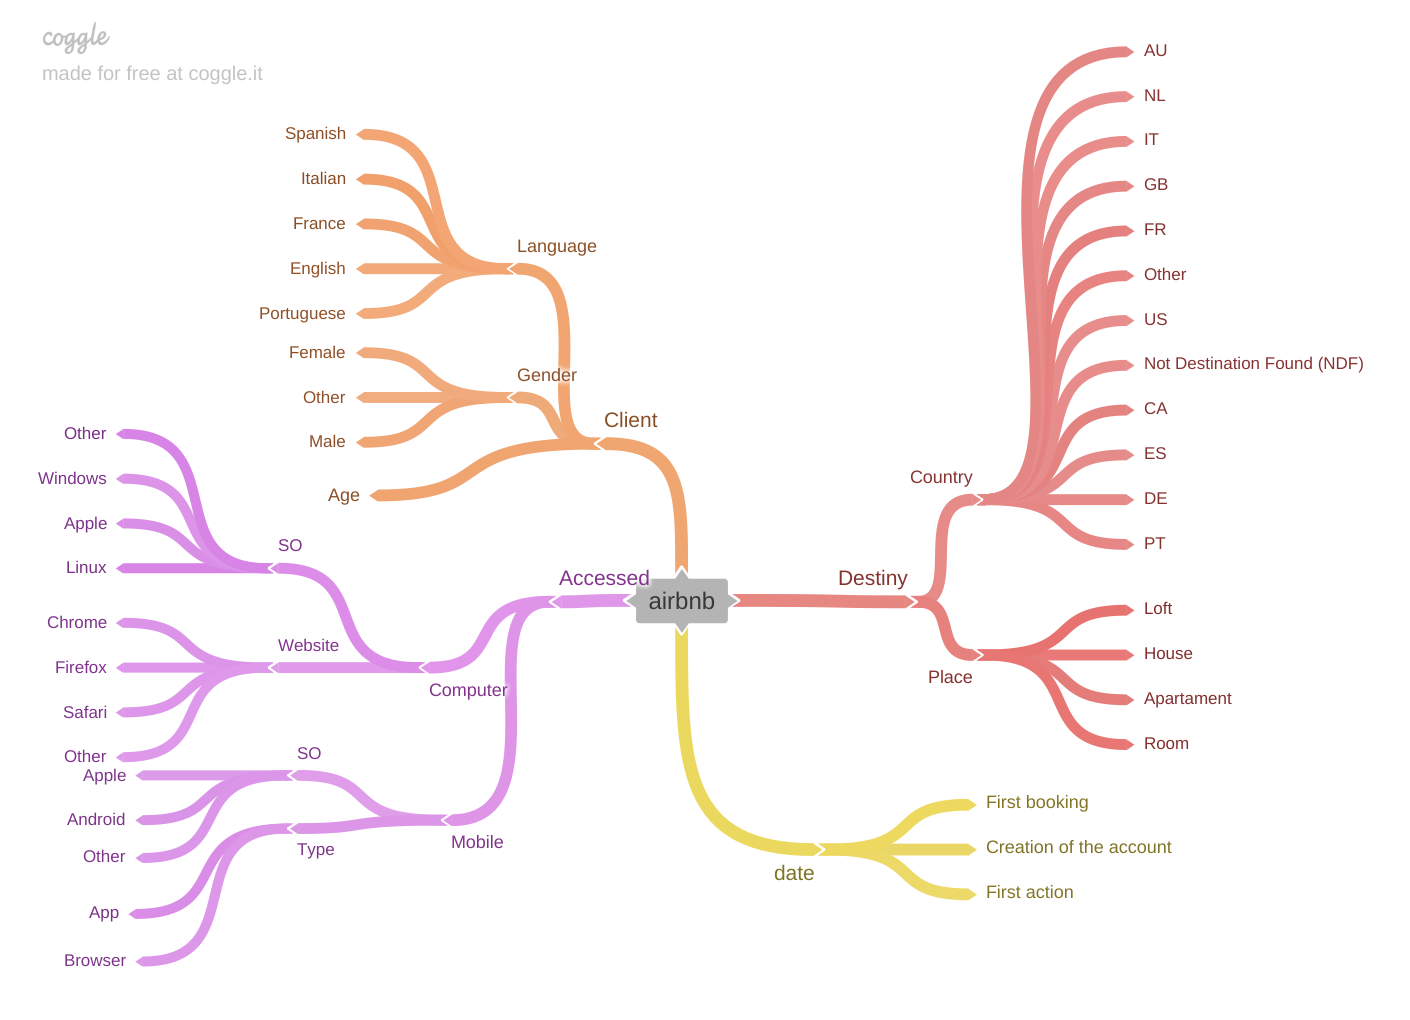

In [14]:
Image('../reports/figures/c1_mind_map.png')

## 2.2 Hypothesis Creation

### 2.2.1 Date

- Most of the appointments took place on the day of account creation.

- 60% or less of the first action occurred on the day of account creation.

- At least 40% of the booking take place during the weekend.

- The number of days since account creation to the first booking is at most 7 days.

### 2.2.2 Client

- At least 60% of customers are at most 40 years old.

- At least 80% of clients use the english language.

- 60% or more of the user are women.

- At most 80% of the user's destination are english-speaking countries.

- Apartments are the types of places most selected by users.

### 2.2.3 Access

- At most 80% of users access by phone.

- The most access acourred by apple's operation systems.

- Linux-based operating systems are the least used.

## 2.3 Final Hypotheses

- Most of the appointments took place on the day of account creation.

- 60% or less of the first action occurred on the day of account creation.

- At least 40% of the first booking take place during the weekend.

- The number of days since account creation to the first booking is at most 7 days.

- At least 60% of customers are at most 40 years old.

- At least 80% of clients use the english language.

- At most 80% of the user's destination are english-speaking countries.

- 60% or more of the user are women.

- At most 80% of users access by phone.

- The most access acourred by apple's operation systems.

## 2.4 Feature Engineering

In [15]:
# Day of week
df2['first_booking_day_of_week'] = df2['date_first_booking'].dt.dayofweek
df2['first_active_account_day_of_week'] = df2['timestamp_first_active'].dt.dayofweek
df2['account_creation_day_of_week'] = df2['date_account_created'].dt.dayofweek

# Day
df2['first_booking_day'] = df2['date_first_booking'].dt.day
df2['first_active_account_day'] = df2['timestamp_first_active'].dt.day
df2['account_creation_day'] = df2['date_account_created'].dt.day

# Month
df2['first_booking_month'] = df2['date_first_booking'].dt.month
df2['first_active_account_month'] = df2['timestamp_first_active'].dt.month
df2['account_creation_month'] = df2['date_account_created'].dt.month

# Year
df2['first_booking_year'] = df2['date_first_booking'].dt.year
df2['first_active_account_year'] = df2['timestamp_first_active'].dt.year
df2['account_creation_year'] = df2['date_account_created'].dt.year

# Day of year
df2['first_booking_day_of_year'] = df2['date_first_booking'].dt.dayofyear
df2['first_active_account_day_of_year'] = df2['timestamp_first_active'].dt.dayofyear
df2['account_creation_day_of_year'] = df2['date_account_created'].dt.dayofyear

# week of year
df2['first_booking_week_of_year'] = df2['date_first_booking'].dt.isocalendar().week
df2['first_active_account_week_of_year'] = df2['timestamp_first_active'].dt.isocalendar().week
df2['account_creation_week_of_year'] = df2['date_account_created'].dt.isocalendar().week

# Days of account creation until the first booking
df2['days_account_creation_first_booking'] = (df2['date_first_booking'] - df2['date_account_created']).dt.days

# Days of first active until acount creation
df2['days_first_active_acount_creation'] = (df2['timestamp_first_active'] - df2['date_account_created']).dt.days

# Days of first active until first booking
df2['days_first_active_first_booking'] = (df2['date_first_booking'] - df2['timestamp_first_active']).dt.days

# 3.0 FIltering Variables

In [16]:
df3 = df2.copy()

## 3.1 Filtering Rows

In [17]:
# Filtering the age
df3 = df3.loc[(df3['age'] >= 18) & (df3['age'] <= 90), :]

# The delay of the creation until the booking will need to be positive
df3 = df3.loc[df3['days_account_creation_first_booking'] >=0, :]

## 3.2 Filtering Columns

In [18]:
# Droping the id column
df3.drop(columns=['id', 'date_first_booking', 'timestamp_first_active', 'date_account_created'], axis=1, inplace=True)

# 4.0 Exploratory Data Analysis

In [19]:
df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.1 Response Variables

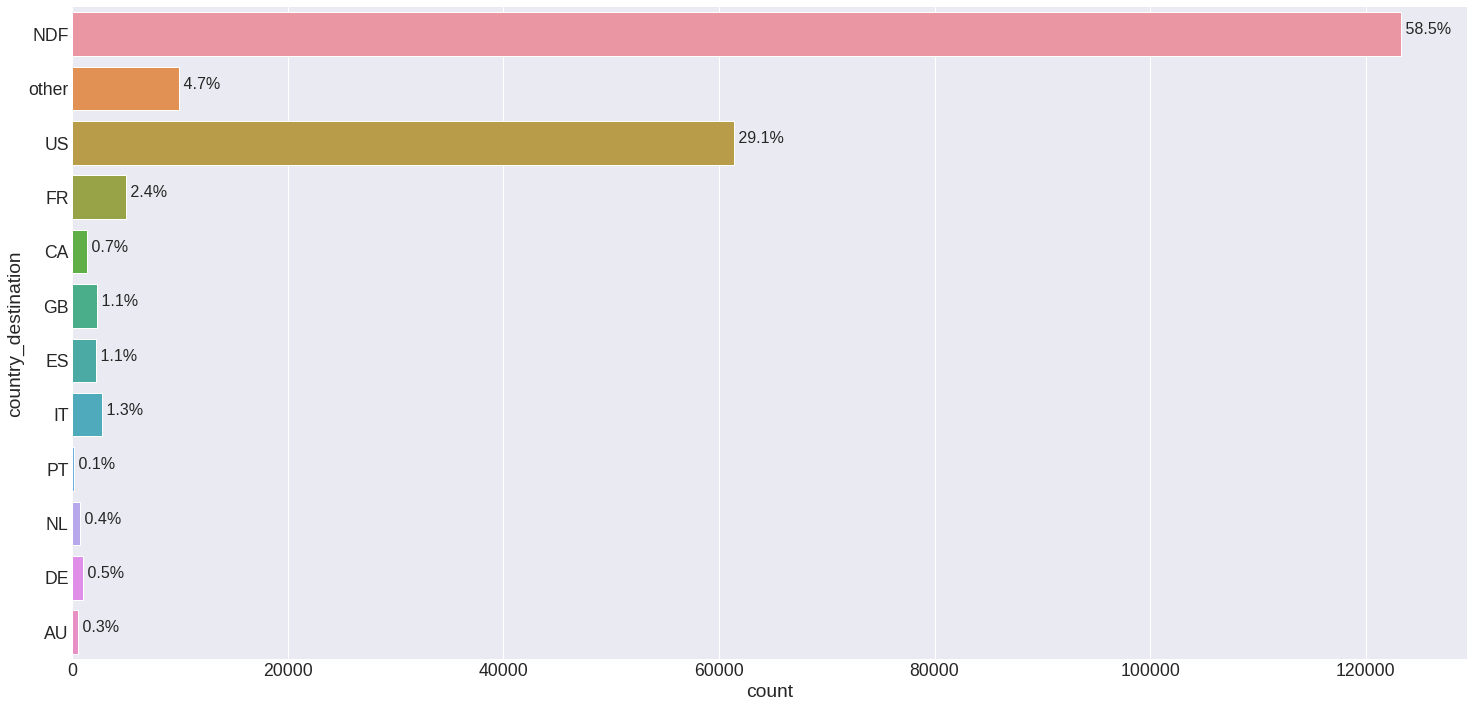

In [27]:
ax = sns.countplot(y='country_destination', data=df4)

total = df4['country_destination'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

### 4.1.2 Numerical Variables

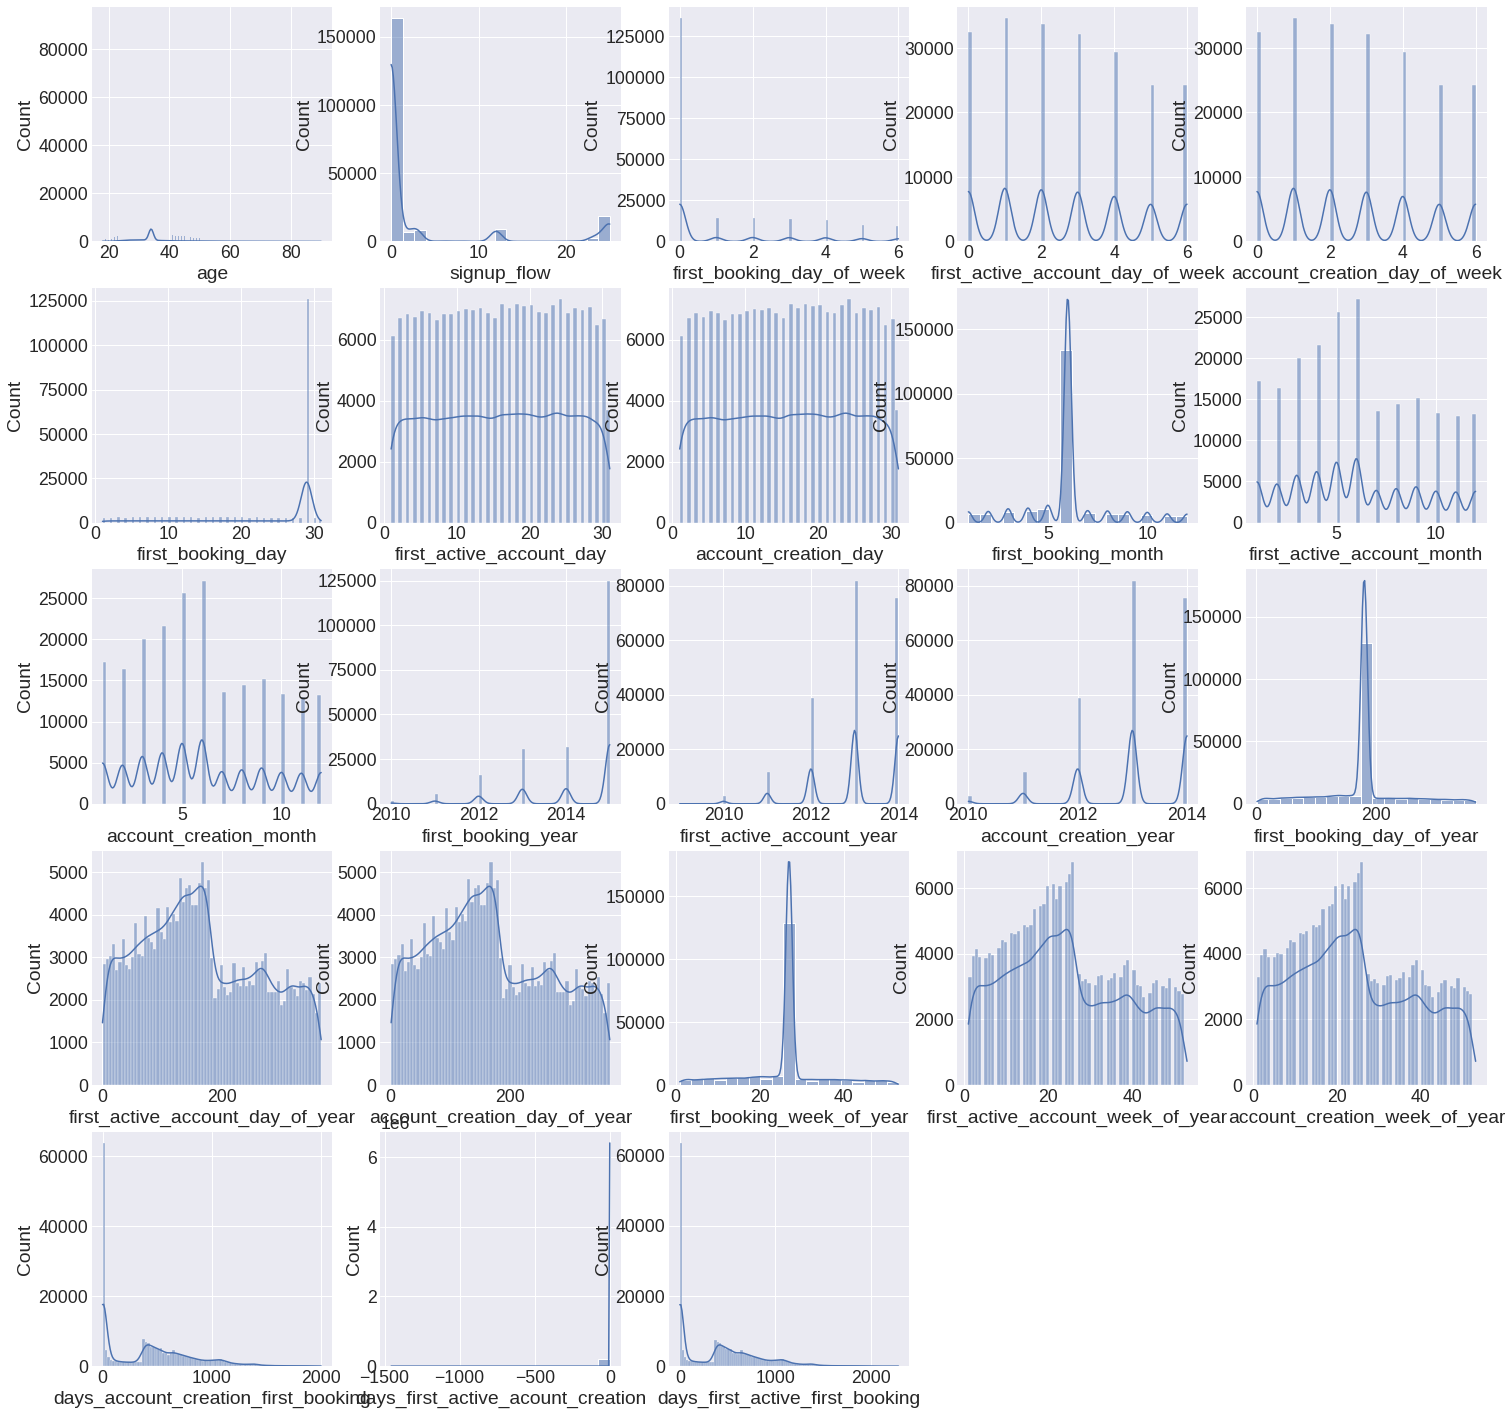

In [28]:
aux1 = df4.select_dtypes(exclude='object')

columns = aux1.columns.tolist()
j = 1

plt.figure(figsize=(25, 25))

for column in columns:
    plt.subplot(5, 5, j)
    sns.histplot(aux1[column], kde=True);

    j += 1

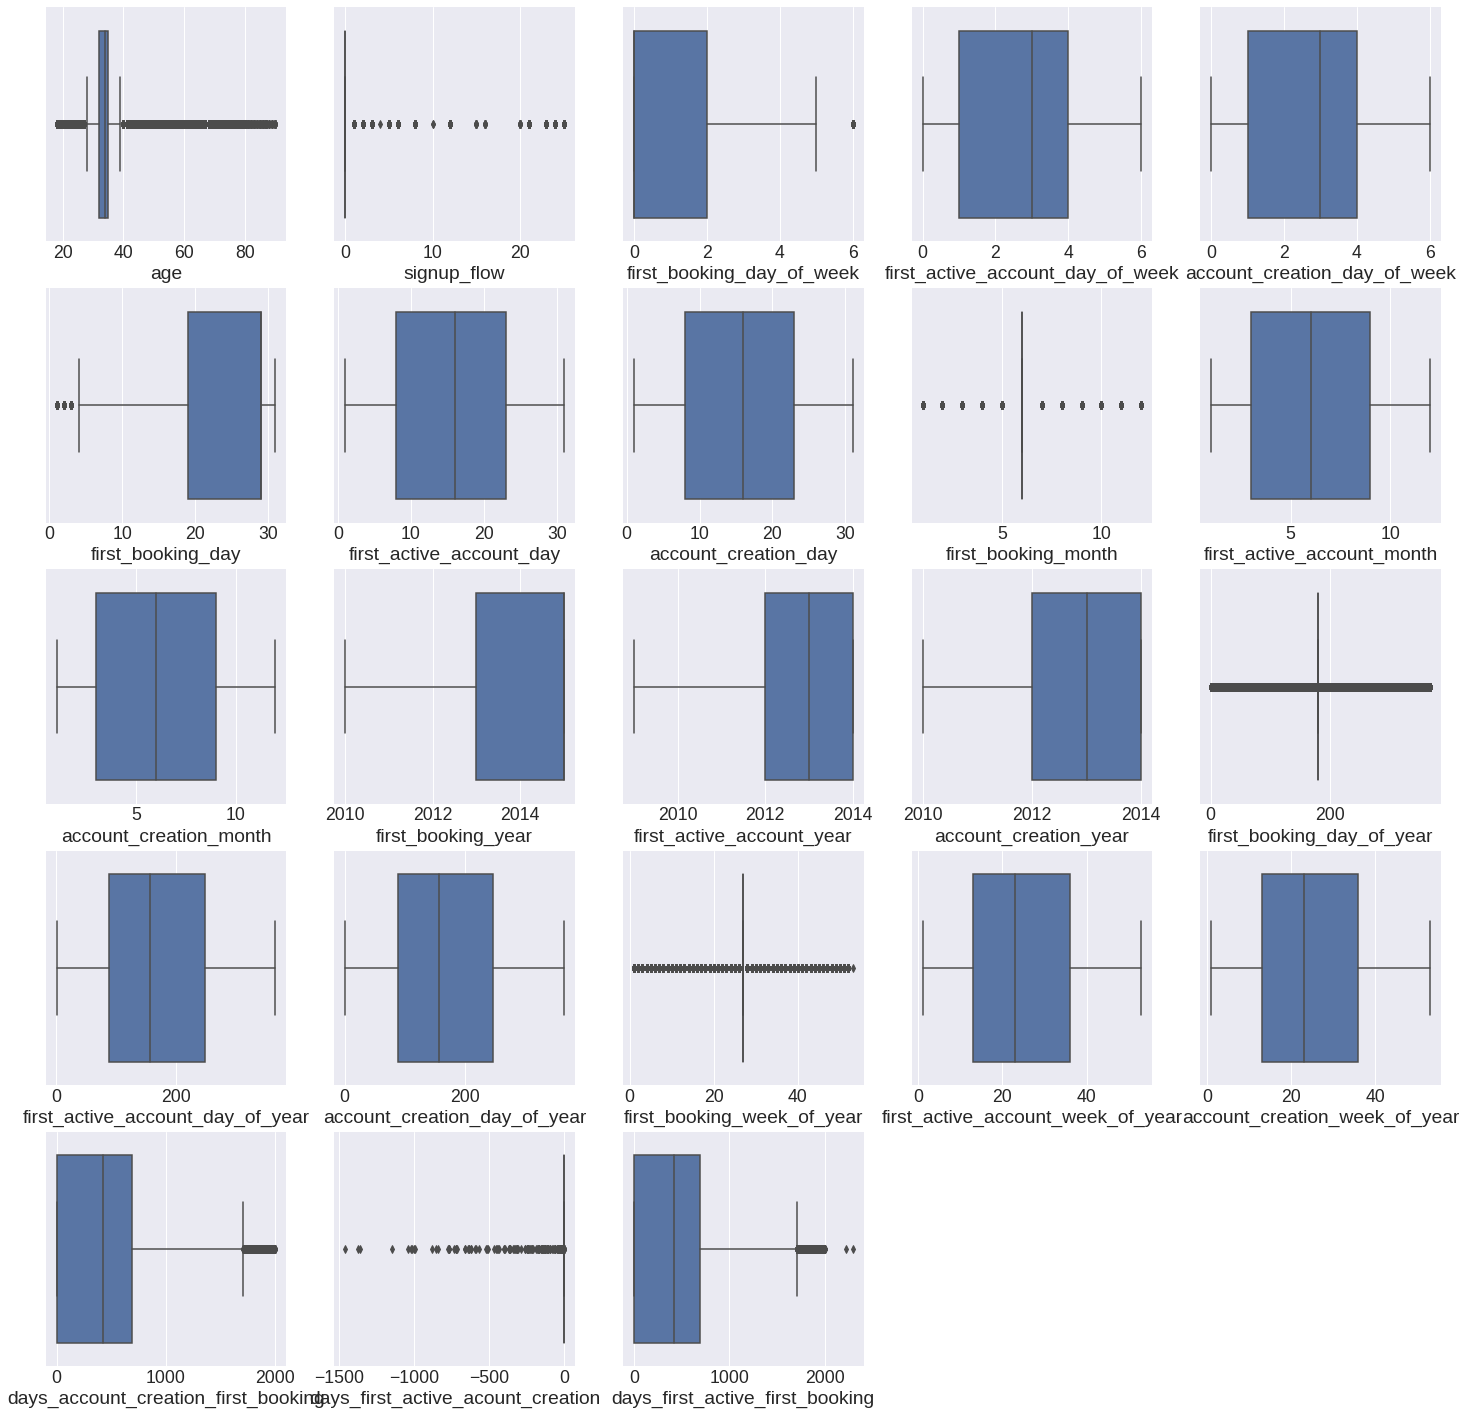

In [29]:
aux1 = df4.select_dtypes(exclude='object')
columns = aux1.columns.tolist()
j = 1

plt.figure(figsize=(25, 25))

for column in columns:
    plt.subplot(5, 5, j)
    sns.boxplot(aux1[column]);

    j += 1

### 4.1.3 Categorical Variables

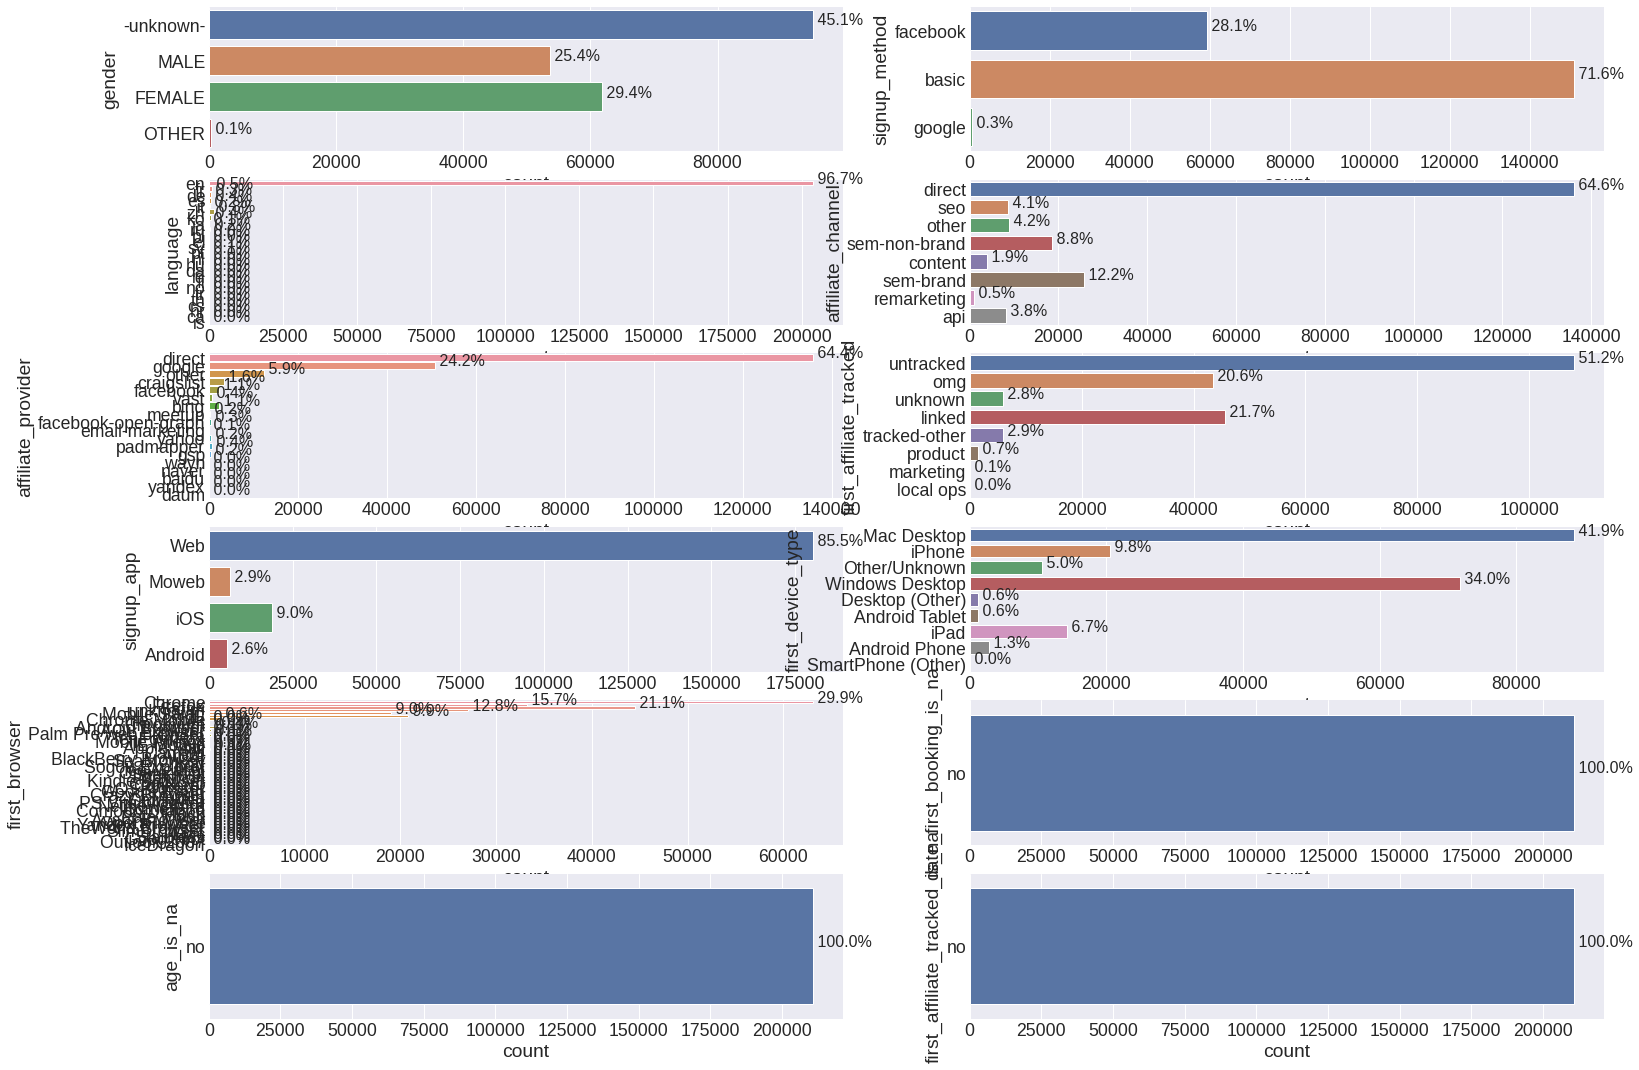

In [30]:
aux1 = df4.drop(columns=['country_destination'], axis=1).select_dtypes(include='object')
columns = aux1.columns.tolist()
j = 1

plt.figure(figsize=(25, 25))

for column in columns:
    plt.subplot(8, 2, j)
    ax = sns.countplot(y=column, data=aux1)
    
    total = aux1[column].size
    for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))
    
    j += 1

## 4.2 Bivariate Analysis

- Most of the appointments took place on the day of account creation.

- 60% or less of the first action occurred on the day of account creation.

- At least 40% of the first booking take place during the weekend.

- The number of days since account creation to the first booking is at most 7 days.

- At least 60% of customers are at most 40 years old.

- At least 80% of clients use the english language.

- At most 80% of the user's destination are english-speaking countries.

- 60% or more of the user are women.

- At most 80% of users access by phone.

- The most access acourred by apple's operation systems.

### H1 80% or more of the first booking occurred at least one day after the creation of the account.
**FALSE**: 80% of the first booking occourred more than one day.

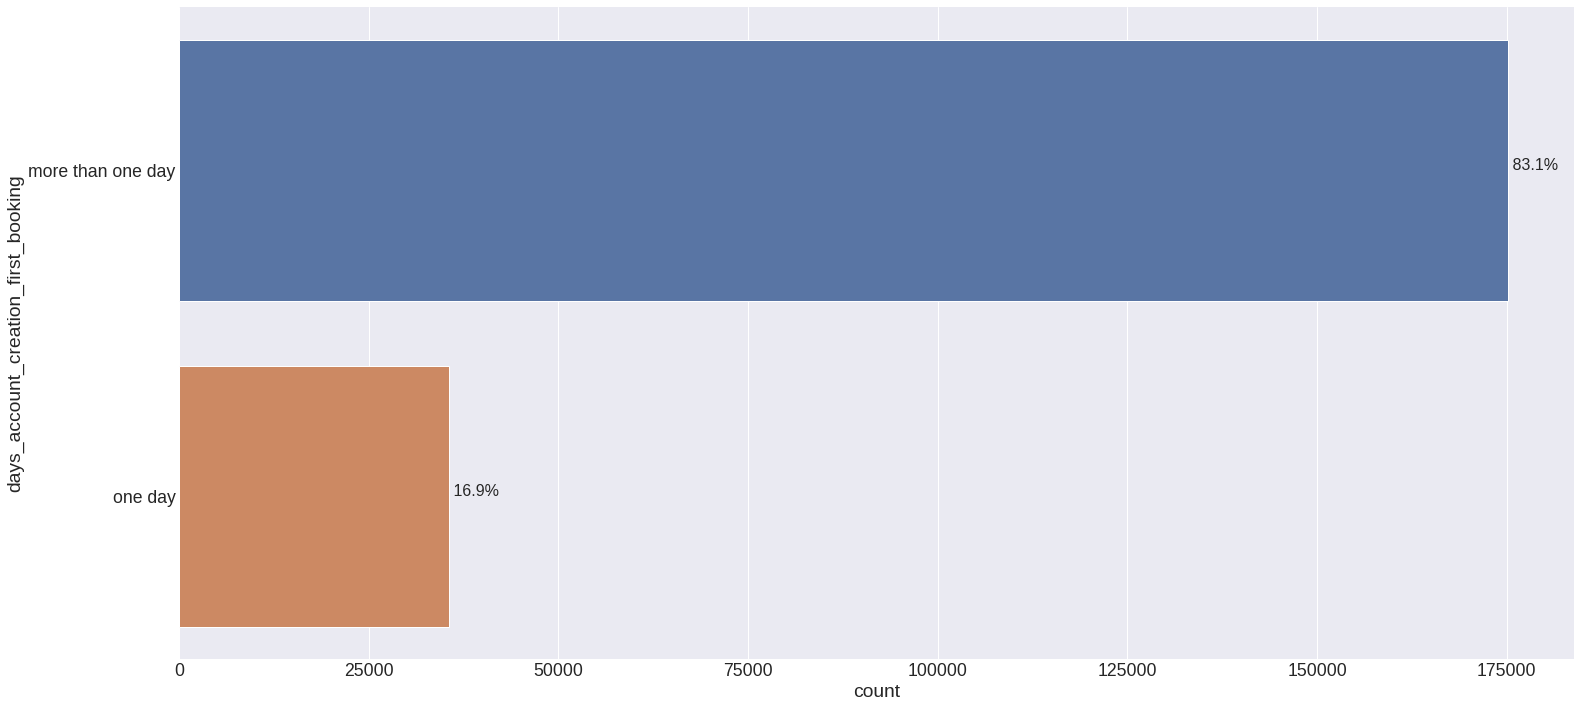

In [31]:
aux = df4['days_account_creation_first_booking'].apply(lambda i: 'one day' if i <= 1 else 'more than one day')

ax = sns.countplot(y=aux)

total = aux.size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

### H2 60% or less of the first action occurred on the day of account creation.
**FALSE**: every active occourred before the creation of the account.

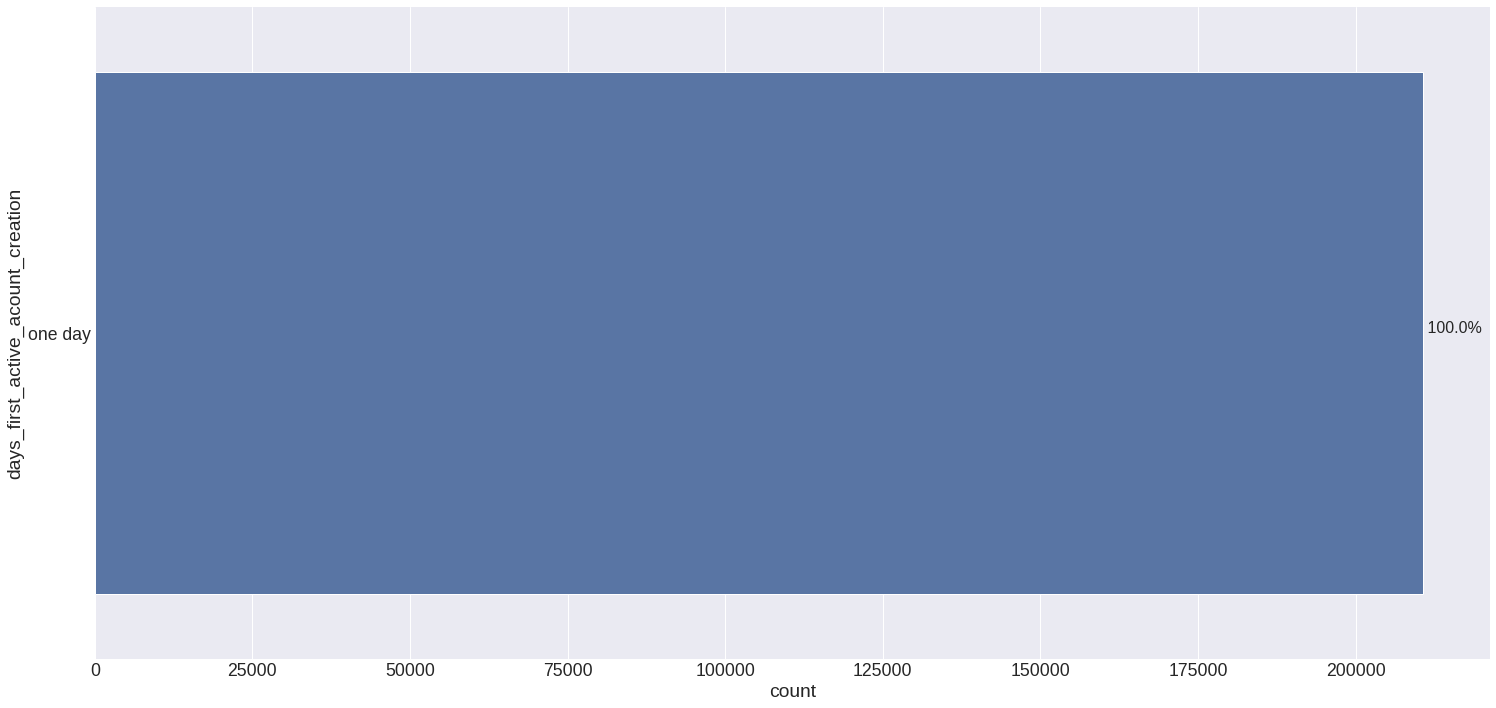

In [32]:
aux = df4['days_first_active_acount_creation'].apply(lambda i: 'one day' if i <= 1 else 'more than one day')

ax = sns.countplot(y=aux)

total = aux.size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

### H3 At least 40% of the first booking take place during the weekend.
**FALSE**: Just 23.3% of the first bookin occourred during the weekend.

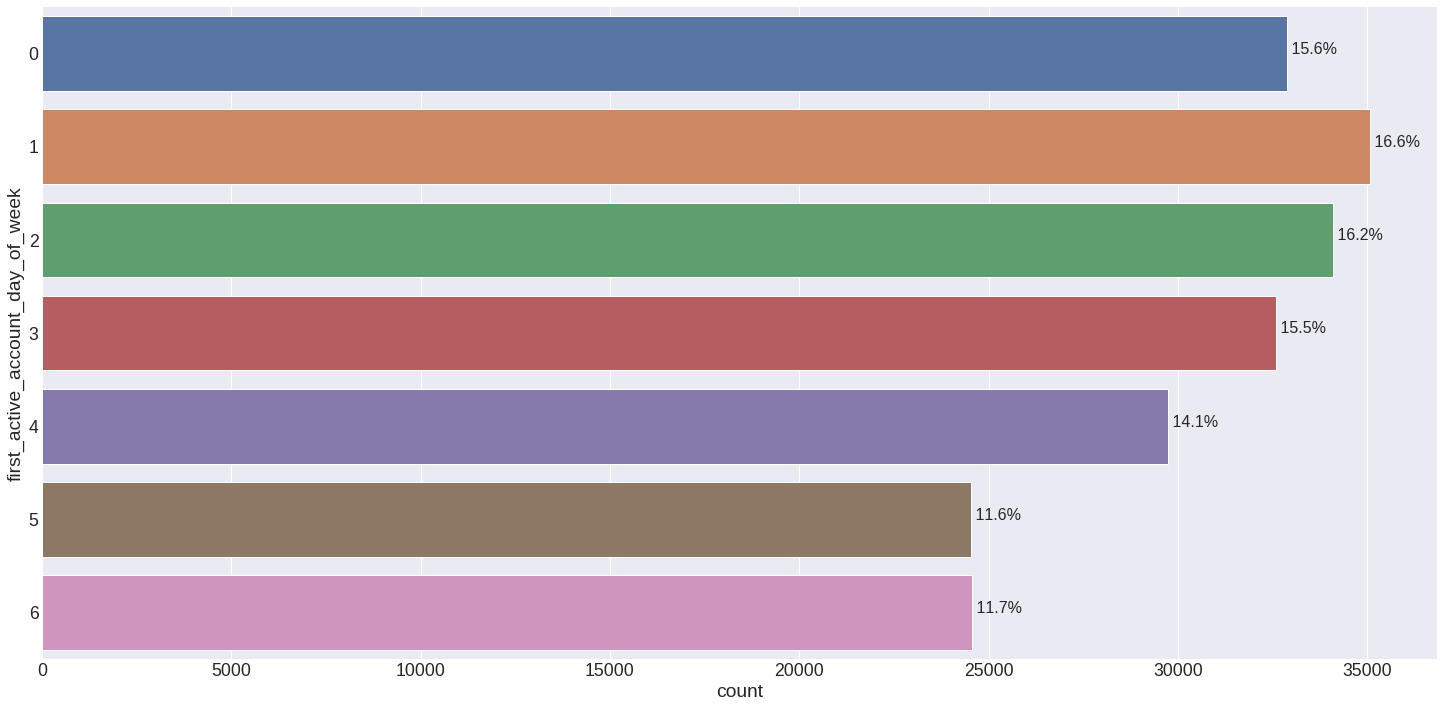

In [33]:
ax = sns.countplot(y='first_active_account_day_of_week', data=df2)

total = df4['first_active_account_day_of_week'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

### H4 The number of days since account creation to the first booking is at most 7 days.
**FALSE**: The first booking may accour more than 7 days.

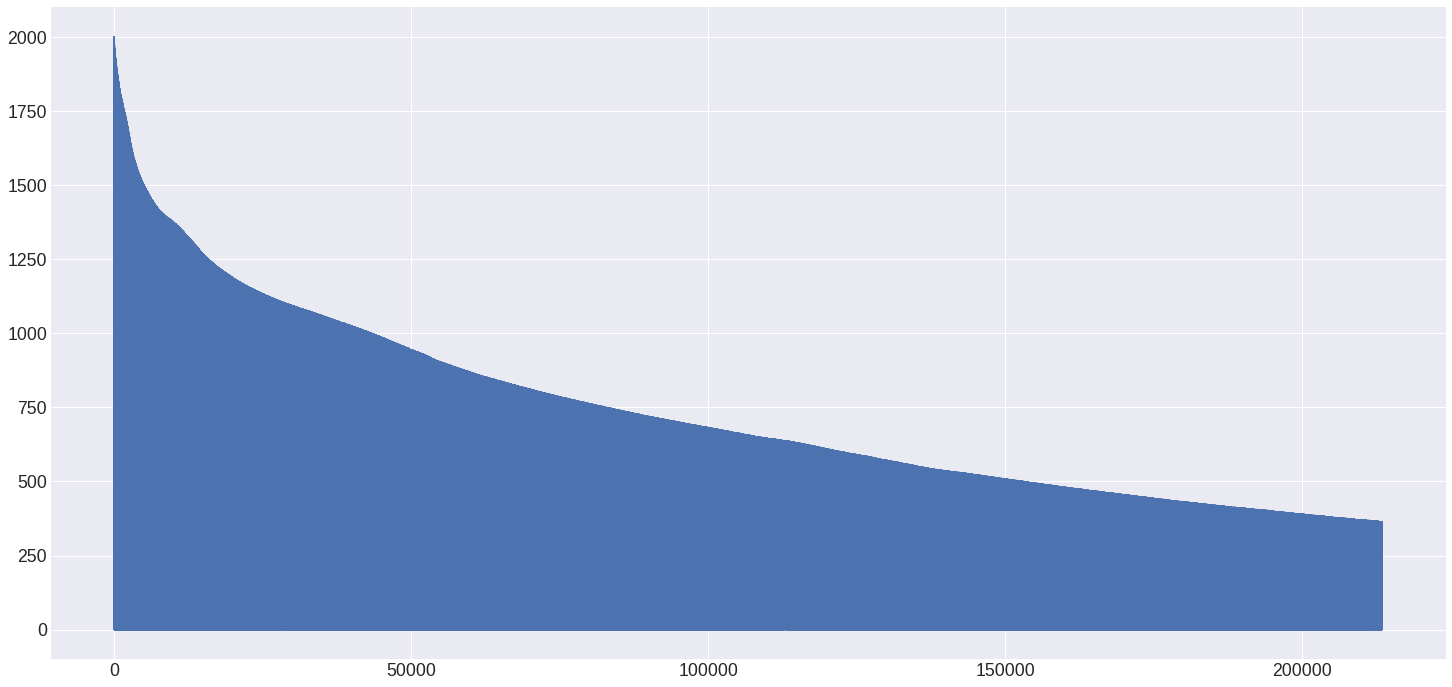

In [34]:
plt.plot(df4['days_account_creation_first_booking']);

### H5 At least 60% of customers are at most 40 years old.
**FALSE**: Just 17.7% of the customers are more than 40 years old.

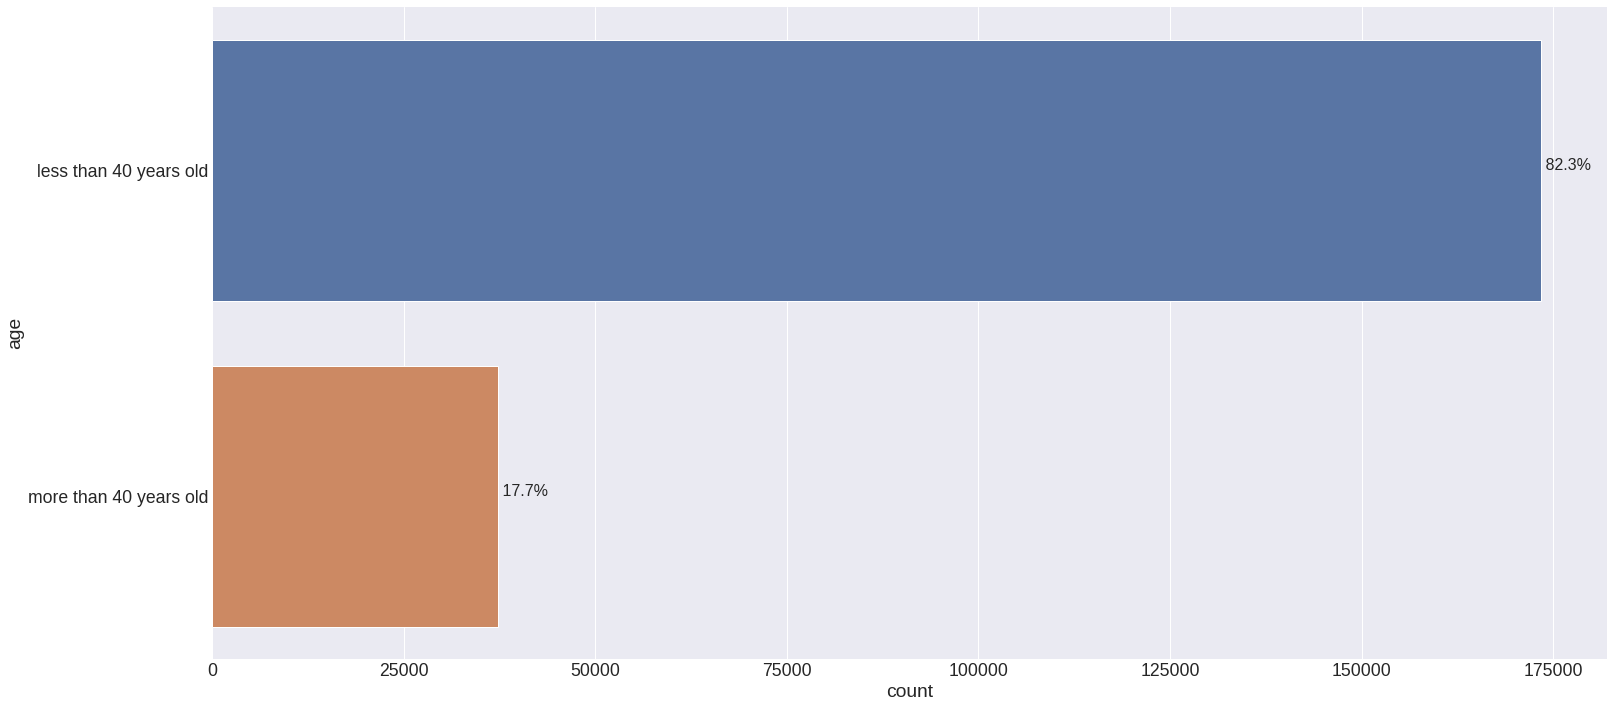

In [35]:
aux = df4['age'].apply(lambda i: 'more than 40 years old' if i >= 40 else 'less than 40 years old')

ax = sns.countplot(y=aux)

total = aux.size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

### H6 At least 80% of clients use the english language.
**TRUE**: The total of customers who use english is 96.7%.

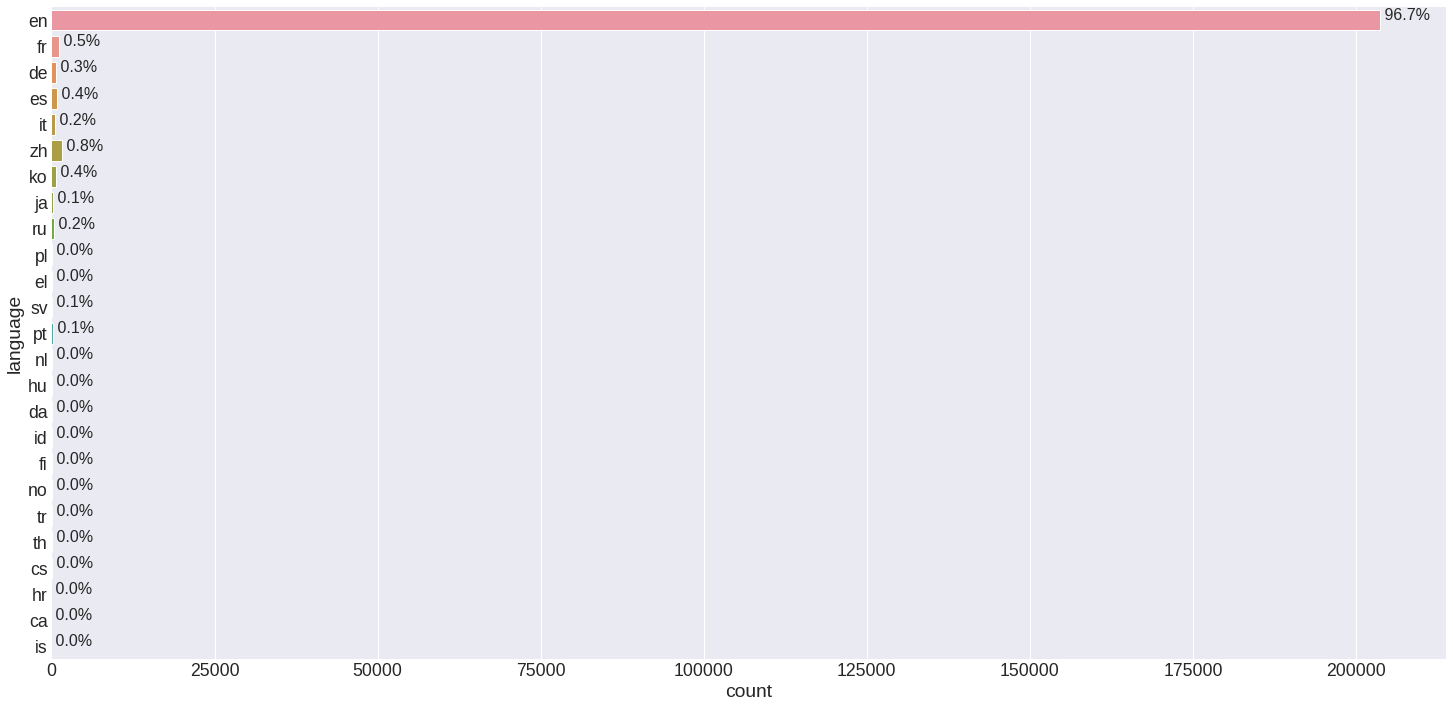

In [36]:
ax = sns.countplot(y='language', data=df4)

total = df4['language'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

### H7 At most 80% of the user's destination are english-speaking countries.
**TRUE**: The english-speaking countries is about 31.2%. 

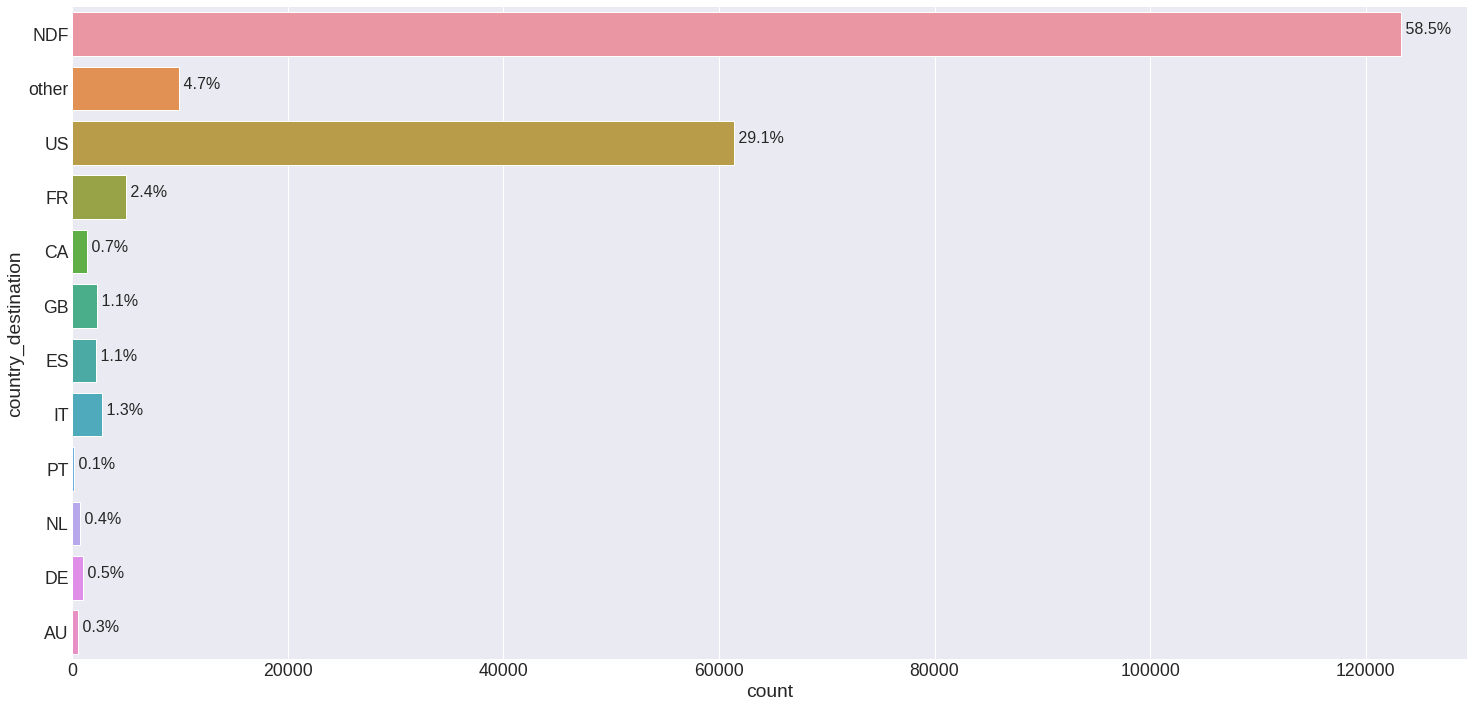

In [37]:
ax = sns.countplot(y='country_destination', data=df4)

total = df4['country_destination'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

### H8 60% or more of the user are women.
**FALSE**: Just 29.4% of the customers are women.

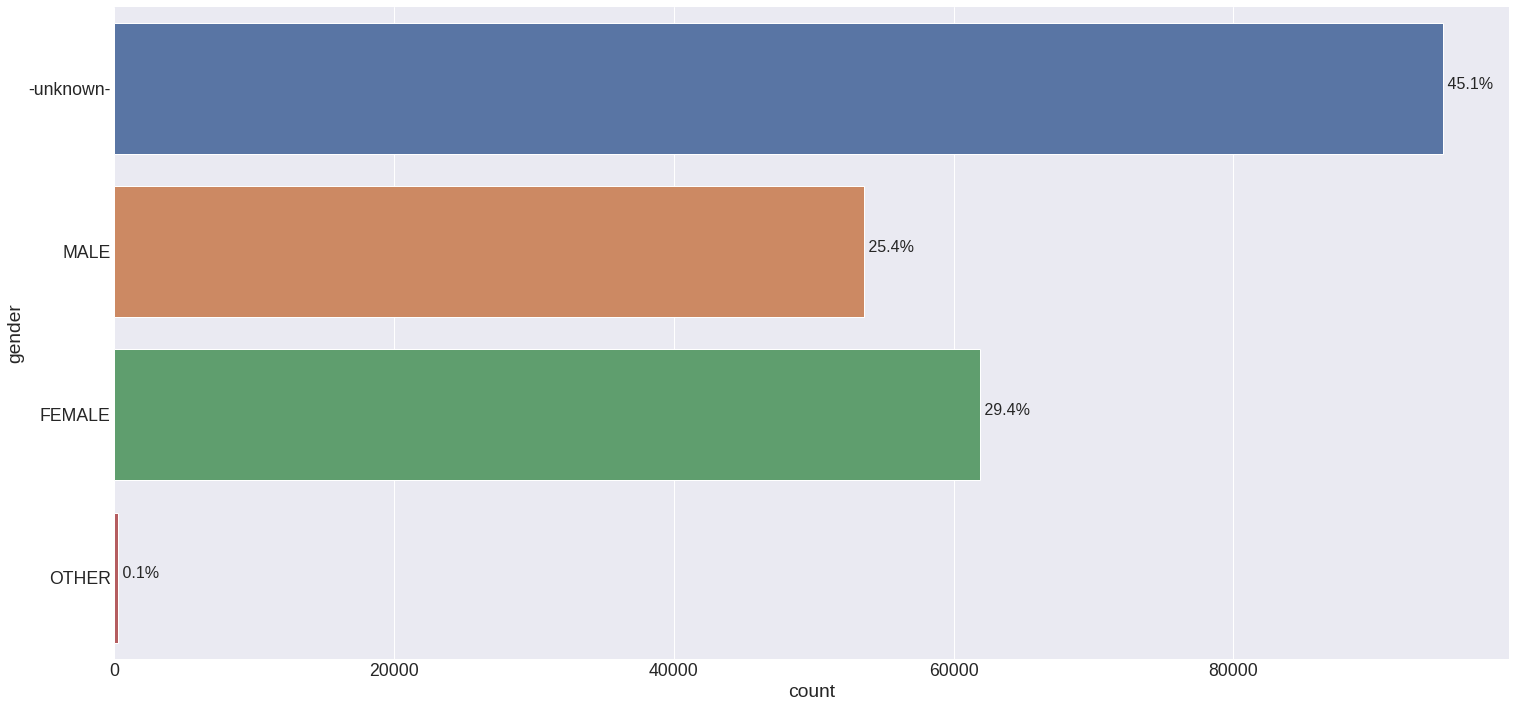

In [38]:
ax = sns.countplot(y='gender', data=df4)

total = df4['gender'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

### H9 At most 80% of users access by phone.
**TRUE**: The total of phone is about 11%.

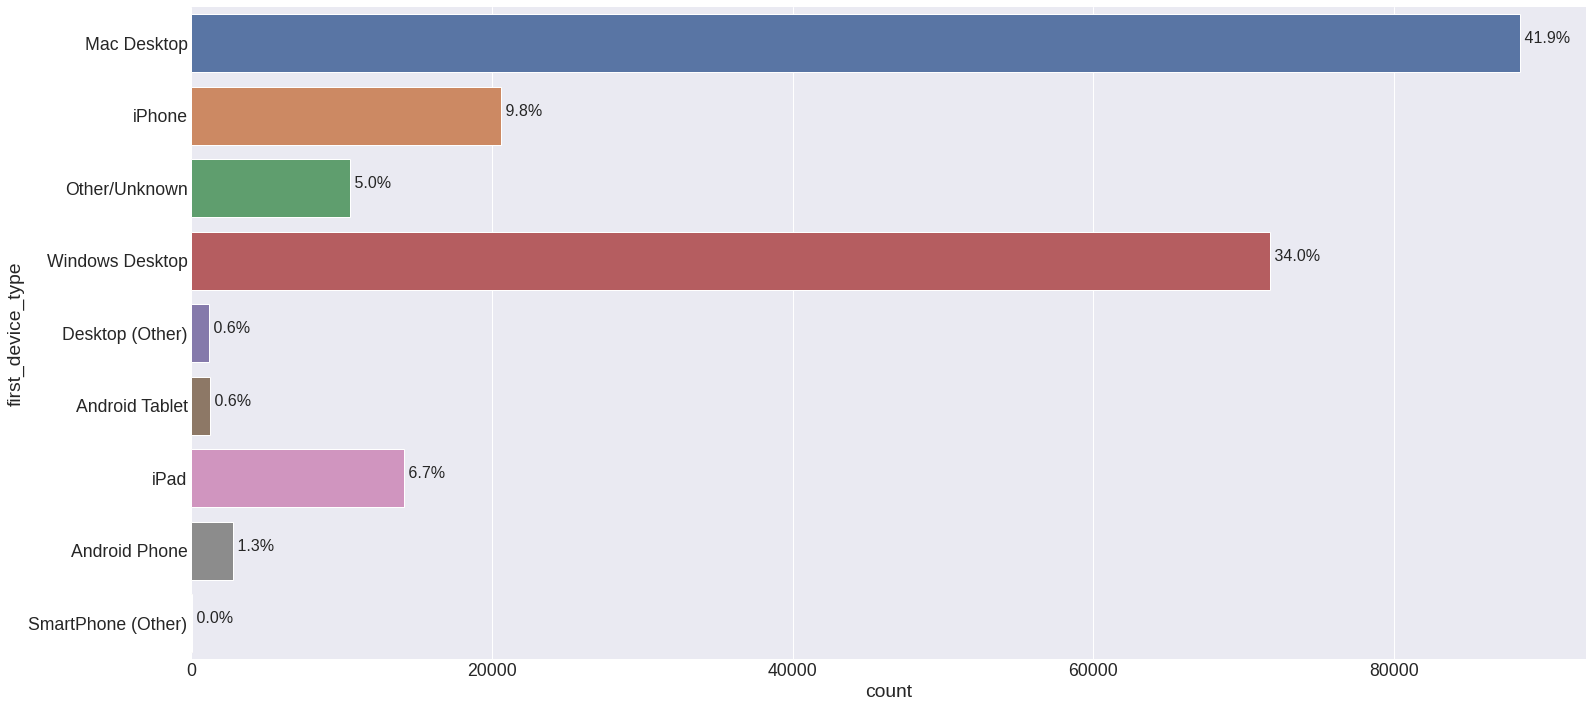

In [39]:
ax = sns.countplot(y='first_device_type', data=df4)

total = df4['first_device_type'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

### H10 The most access acourred by apple's operation systems.
**TRUE**: The most access acourred by apple's operation systems. It's about 58.4%.

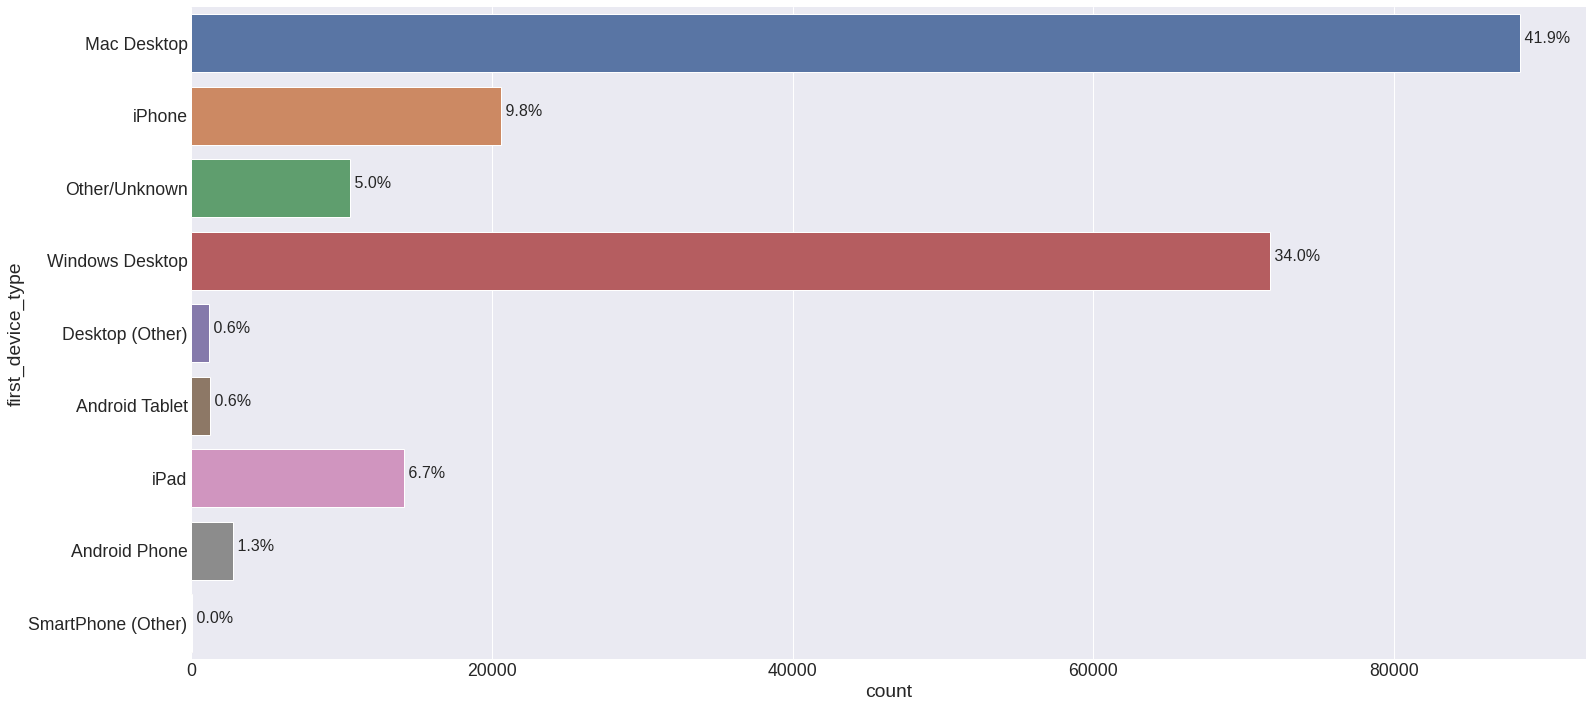

In [40]:
ax = sns.countplot(y='first_device_type', data=df4)

total = df4['first_device_type'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

## 4.3 Multivariate Analysis

### 4.3.1 Numerical Variables

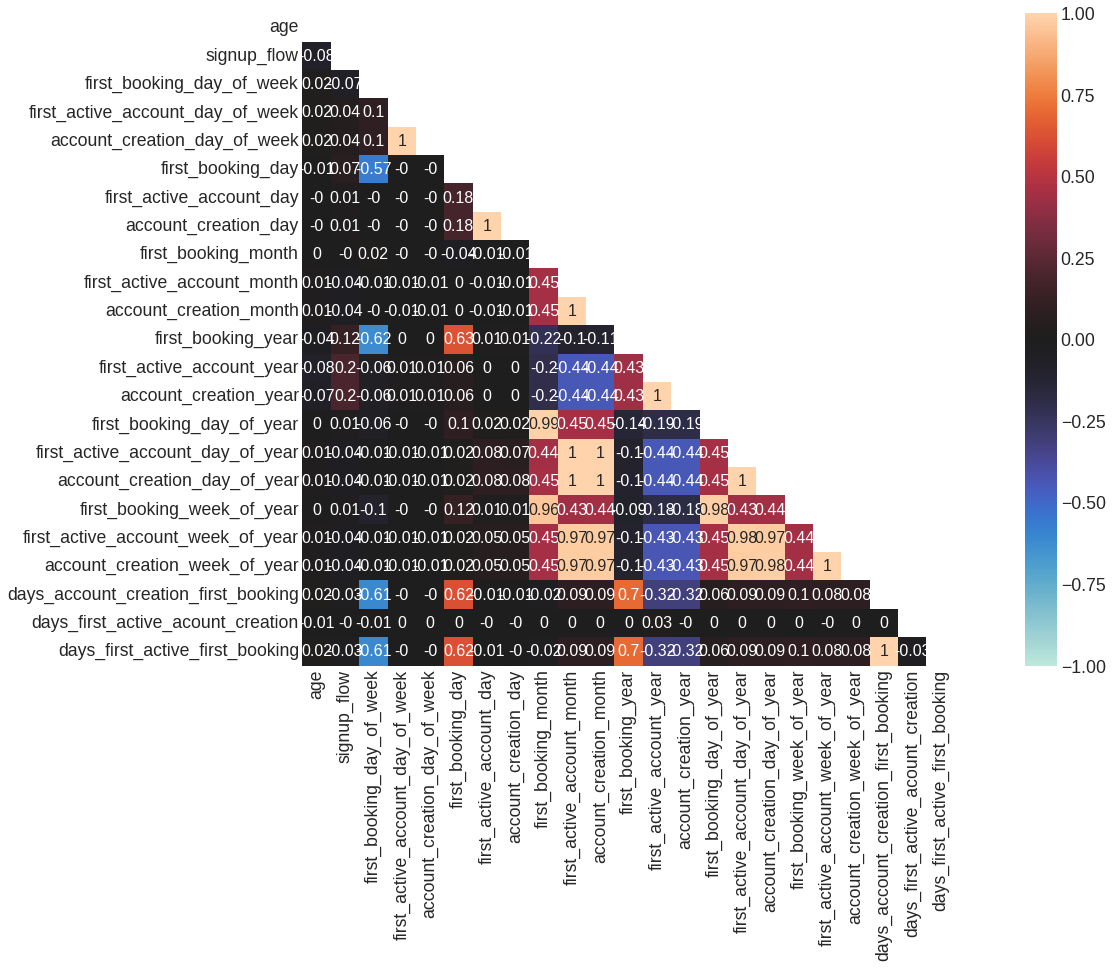

In [41]:
plt.figure(figsize=(25, 12))

corr = df4.select_dtypes(exclude='object').corr().round(2)

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    ax = sns.heatmap(corr, annot=True, mask=mask, vmin=-1, center=0, vmax=1, square=True)

### 4.3.2 Categorical Variables

In [42]:
cat_attributes = df4.select_dtypes(include='object')
dict_corr = {}
columns = cat_attributes.columns.tolist()

for column in columns:
    dict_corr[column] = {}
    
    for column2 in columns:
        dict_corr[column][column2] = calcCramerV(cat_attributes[column], cat_attributes[column2])
        
corr = pd.DataFrame(dict_corr)

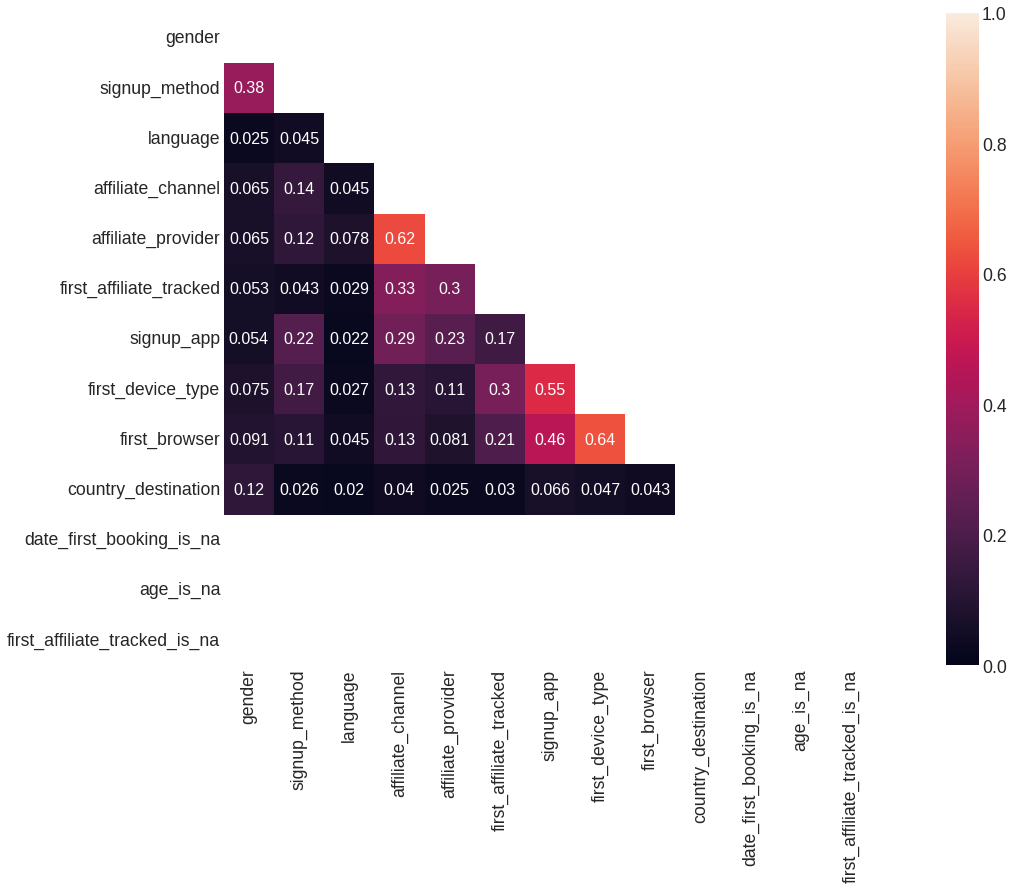

In [43]:
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    ax = sns.heatmap(corr, annot=True, mask=mask, vmin=0, vmax=1, square=True)

# 5.0 Data Preparation

In [20]:
df5 = df4.copy()

## 5.1 Spliting into X and y

In [21]:
X = df5.drop(columns=['country_destination'], axis=1)
y = df5['country_destination']

In [22]:
# convert the target to label encode
le = LabelEncoder()
y = le.fit_transform(y)

y = pd.Series(y, name='country_destination')

## 5.2 One Hot Encoders

In [23]:
ohe = OneHotEncoder(cols=['date_first_booking_is_na', 'age_is_na', 'first_affiliate_tracked_is_na'], use_cat_names=True)
X = ohe.fit_transform(X)

## 5.4 Nature Transformation

In [24]:
# Transformation of day of week
for c in ['first_active_account_day_of_week', 'account_creation_day_of_week', 'first_booking_day_of_week']:
    
    X[c + '_sin'] = X[c].apply(lambda i: np.sin(i*(2*np.pi/7)))
    X[c + '_cos'] = X[c].apply(lambda i: np.cos(i*(2*np.pi/7)))
    X[c + '_rescaled'] = X[c].apply(lambda i: i/7)


# Transformation of day of month
for c in ['first_booking_day', 'first_active_account_day', 'account_creation_day']:
    
    X[c + '_sin'] = X[c].apply(lambda i: np.sin(i*2*np.pi/30))
    X[c + '_cos'] = X[c].apply(lambda i: np.cos(i*2*np.pi/30))
    X[c + '_rescaled'] = X[c].apply(lambda i: i/30)


# Transformation of month
for c in ['first_booking_month', 'first_active_account_month', 'account_creation_month']:
    
    X[c + '_sin'] = X[c].apply(lambda i: np.sin(i*2*np.pi/12))
    X[c + '_cos'] = X[c].apply(lambda i: np.cos(i*2*np.pi/12))
    X[c + '_rescaled'] = X[c].apply(lambda i: i/12)


# Transformation of day of year
for c in ['first_booking_day_of_year', 'first_active_account_day_of_year', 'account_creation_day_of_year']:
    
    X[c + '_sin'] = X[c].apply(lambda i: np.sin(i*2*np.pi/365))
    X[c + '_cos'] = X[c].apply(lambda i: np.cos(i*2*np.pi/365))
    X[c + '_rescaled'] = X[c].apply(lambda i: i/365)


# Transformation of week of year
for c in ['first_booking_week_of_year', 'first_active_account_week_of_year', 'account_creation_week_of_year']:
    
    X[c + '_sin'] = X[c].apply(lambda i: np.sin(i*2*np.pi/52))
    X[c + '_cos'] = X[c].apply(lambda i: np.cos(i*2*np.pi/52))
    X[c + '_rescaled'] = X[c].apply(lambda i: i/52)

## 5.5 Split into Train, Valid and Test

In [25]:
# spliting into temp and test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=.3, stratify=y)

# spliting into train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=.3, stratify=y_temp)

## 5.3 Target Encoder

In [26]:
cols = ['gender', 'signup_method', 'language', 'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser']
te = TargetEncoder(cols=cols, handle_missing='value', handle_unknown='value')

X_train = te.fit_transform(X_train, y_train)
X_valid = te.transform(X_valid, y_valid)

X_params = te.fit_transform(X_temp, y_temp)
X_test = te.transform(X_test, y_test)

In [27]:
# filling na with 0
X_params = X_params.fillna(0)
X_test = X_test.fillna(0)

X_train = X_train.fillna(0)
X_valid = X_valid.fillna(0)

## 5.3 Robust Scaler

In [28]:
rs = RobustScaler()

columns = [
    'age', 'signup_flow', 'first_booking_day', 'first_active_account_day', 'account_creation_day', 'first_booking_year', 'first_active_account_year', 
    'account_creation_year', 'first_booking_day_of_year', 'first_active_account_day_of_year', 'account_creation_day_of_year', 'first_booking_week_of_year', 
    'first_active_account_week_of_year', 'account_creation_week_of_year', 'days_account_creation_first_booking', 'days_first_active_acount_creation', 
    'days_first_active_first_booking', 'first_booking_month', 'first_active_account_month', 'account_creation_month']

In [29]:
X_train[columns] = rs.fit_transform(X_train[columns])
X_valid[columns] = rs.transform(X_valid[columns])

X_params[columns] = rs.fit_transform(X_params[columns])
X_test[columns] = rs.transform(X_test[columns])

# 6.0 Feature Selection

## 6.1 Boruta + Extra Trees

In [54]:
X_boruta = X_train.values
y_boruta = y_train.values.ravel()

In [55]:
etc = ExtraTreesClassifier(class_weight='balanced', n_jobs=10)

boruta = BorutaPy(etc, n_estimators='auto')
boruta.fit(X_boruta, y_boruta)

BorutaPy(estimator=ExtraTreesClassifier(class_weight='balanced',
                                        n_estimators=48, n_jobs=10,
                                        random_state=RandomState(MT19937) at 0x7F5284484340),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7F5284484340)

In [56]:
cols_selected_boruta = boruta.support_.tolist()
columns_selected = X_train.loc[:, cols_selected_boruta].columns.tolist()

columns_selected

['first_booking_day_of_week',
 'first_booking_day',
 'first_booking_year',
 'days_account_creation_first_booking',
 'days_first_active_first_booking',
 'first_booking_day_of_week_cos',
 'first_booking_day_of_week_rescaled',
 'first_booking_day_sin',
 'first_booking_day_cos',
 'first_booking_day_rescaled',
 'first_booking_day_of_year_cos']

In [57]:
columns_selected_ext = [
    'first_booking_day_of_week',
    'first_booking_day',
    'first_booking_year',
    'days_account_creation_first_booking',
    'days_first_active_first_booking',
    'first_booking_day_of_week_sin',
    'first_booking_day_of_week_cos',
    'first_booking_day_of_week_rescaled',
    'first_booking_day_sin',
    'first_booking_day_cos',
    'first_booking_day_rescaled',
    'first_booking_day_of_year_cos']

### 6.1.2 Results

In [58]:
etc.fit(X_train.loc[:, columns_selected_ext], y_train)
y_pred = etc.predict(X_valid.loc[:, columns_selected_ext])

ml_scores('', y_valid, y_pred)

,Accuracy,Precision,Recall,F1,Kappa
,0.1728,0.1687,0.7244,0.1625,0.5406


## 6.2 Boruta + Random Forest

In [59]:
X_boruta = X_train.values
y_boruta = y_train.values.ravel()

In [60]:
rf = RandomForestClassifier(class_weight='balanced', n_jobs=10)

boruta = BorutaPy(rf, n_estimators='auto')
boruta.fit(X_boruta, y_boruta)

BorutaPy(estimator=RandomForestClassifier(class_weight='balanced',
                                          n_estimators=24, n_jobs=10,
                                          random_state=RandomState(MT19937) at 0x7F5284484340),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7F5284484340)

In [61]:
cols_selected_boruta = boruta.support_.tolist()
columns_selected = X_train.loc[:, cols_selected_boruta].columns.tolist()

columns_selected

['first_booking_day_of_year_cos']

In [62]:
columns_selected_rf = ['days_account_creation_first_booking', 'first_booking_day_of_year_cos']

### 6.2.1 Results

In [63]:
etc.fit(X_train.loc[:, columns_selected_rf], y_train)
y_pred = etc.predict(X_valid.loc[:, columns_selected_rf])

ml_scores('', y_valid, y_pred)

,Accuracy,Precision,Recall,F1,Kappa
,0.1742,0.1701,0.6745,0.149,0.4758


## 6.3 Select From Model + Extra Trees

In [64]:
etc = ExtraTreesClassifier(n_jobs=10, class_weight='balanced')
sfm = SelectFromModel(etc)

sfm.fit(X_train, y_train)

SelectFromModel(estimator=ExtraTreesClassifier(class_weight='balanced',
                                               n_jobs=10))

In [65]:
cols_selected_sfm = sfm.get_support()
columns_selected = X_train.loc[:, cols_selected_sfm].columns.tolist()

columns_selected

['gender',
 'age',
 'signup_method',
 'signup_flow',
 'affiliate_channel',
 'affiliate_provider',
 'first_affiliate_tracked',
 'first_device_type',
 'first_browser',
 'first_booking_day_of_week',
 'first_booking_day',
 'first_booking_year',
 'first_booking_day_of_year',
 'days_account_creation_first_booking',
 'days_first_active_first_booking',
 'first_booking_day_of_week_sin',
 'first_booking_day_of_week_cos',
 'first_booking_day_of_week_rescaled',
 'first_booking_day_sin',
 'first_booking_day_cos',
 'first_booking_day_rescaled',
 'first_active_account_day_cos',
 'account_creation_day_cos',
 'first_booking_day_of_year_sin',
 'first_booking_day_of_year_cos',
 'first_booking_day_of_year_rescaled',
 'first_booking_week_of_year_cos']

### 6.3.1 Results

In [66]:
etc.fit(X_train.loc[:, columns_selected], y_train)
y_pred = etc.predict(X_valid.loc[:, columns_selected])

ml_scores('', y_valid, y_pred)

,Accuracy,Precision,Recall,F1,Kappa
,0.1681,0.1725,0.8577,0.1619,0.739


## 6.4 Select From Model + Random Forest

In [67]:
rf = RandomForestClassifier(n_jobs=10, class_weight='balanced')
sfm = SelectFromModel(rf)

sfm.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(class_weight='balanced',
                                                 n_jobs=10))

In [68]:
cols_selected_sfm = sfm.get_support()
columns_selected = X_train.loc[:, cols_selected_sfm].columns.tolist()

In [69]:
columns_selected = [
    'gender',
    'age',
    'affiliate_channel',
    'affiliate_provider',
    'first_affiliate_tracked',
    'first_device_type',
    'first_browser',
    'first_booking_day_of_week',
    'first_booking_day',
    'first_active_account_day',
    'account_creation_day',
    'first_booking_year',
    'first_booking_day_of_year',
    'first_active_account_day_of_year',
    'account_creation_day_of_year',
    'days_account_creation_first_booking',
    'days_first_active_first_booking',
    'first_booking_day_of_week_sin',
    'first_booking_day_of_week_cos',
    'first_booking_day_of_week_rescaled',
    'first_booking_day_sin',
    'first_booking_day_cos',
    'first_booking_day_rescaled',
    'first_active_account_day_sin',
    'first_active_account_day_cos',
    'first_active_account_day_rescaled',
    'account_creation_day_sin',
    'account_creation_day_cos',
    'account_creation_day_rescaled',
    'first_booking_day_of_year_sin',
    'first_booking_day_of_year_cos',
    'first_booking_day_of_year_rescaled',
    'first_active_account_day_of_year_sin',
    'first_active_account_day_of_year_cos',
    'first_active_account_day_of_year_rescaled',
    'account_creation_day_of_year_sin',
    'account_creation_day_of_year_cos',
    'account_creation_day_of_year_rescaled']

### 6.4.1 Results

In [70]:
rf.fit(X_train.loc[:, columns_selected], y_train)
y_pred = rf.predict(X_valid.loc[:, columns_selected])

ml_scores('', y_valid, y_pred)

,Accuracy,Precision,Recall,F1,Kappa
,0.1672,0.1718,0.867,0.1572,0.7542


# 7.0 Machine Learning Model

In [44]:
selected_columns = [
    'gender', 'age', 'signup_method', 'signup_flow', 'affiliate_channel',
    'affiliate_provider', 'first_affiliate_tracked', 'first_device_type',
    'first_browser', 'first_booking_day_of_week', 'first_booking_day',
    'first_booking_year', 'first_booking_day_of_year', 'days_account_creation_first_booking',
    'days_first_active_first_booking', 'first_booking_day_of_week_sin', 'first_booking_day_of_week_cos',
    'first_booking_day_of_week_rescaled', 'first_booking_day_sin', 'first_booking_day_cos',
    'first_booking_day_rescaled', 'first_active_account_day_cos', 'account_creation_day_cos',
    'first_booking_day_of_year_sin', 'first_booking_day_of_year_cos', 'first_booking_day_of_year_rescaled',
    'first_booking_week_of_year_cos']

In [45]:
X_train_sc = X_train.loc[:, selected_columns]
X_valid_sc = X_valid.loc[:, selected_columns]

X_params_sc = X_params.loc[:, selected_columns]
X_test_sc = X_test.loc[:, selected_columns]

## 7.1 Baseline Model

In [73]:
dummy = DummyClassifier()
dummy.fit(X_train_sc, y_train)

y_pred = dummy.predict(X_valid_sc)

In [74]:
dummy_results = ml_scores('dummy', y_valid, y_pred)
dummy_results

,Accuracy,Precision,Recall,F1,Kappa
dummy,0.0833,0.0487,0.5848,0.0615,0.0


In [75]:
print(mtr.classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       111
           1       0.00      0.00      0.00       295
           2       0.00      0.00      0.00       219
           3       0.00      0.00      0.00       466
           4       0.00      0.00      0.00      1042
           5       0.00      0.00      0.00       480
           6       0.00      0.00      0.00       584
           7       0.58      1.00      0.74     25879
           8       0.00      0.00      0.00       158
           9       0.00      0.00      0.00        45
          10       0.00      0.00      0.00     12890
          11       0.00      0.00      0.00      2083

    accuracy                           0.58     44252
   macro avg       0.05      0.08      0.06     44252
weighted avg       0.34      0.58      0.43     44252



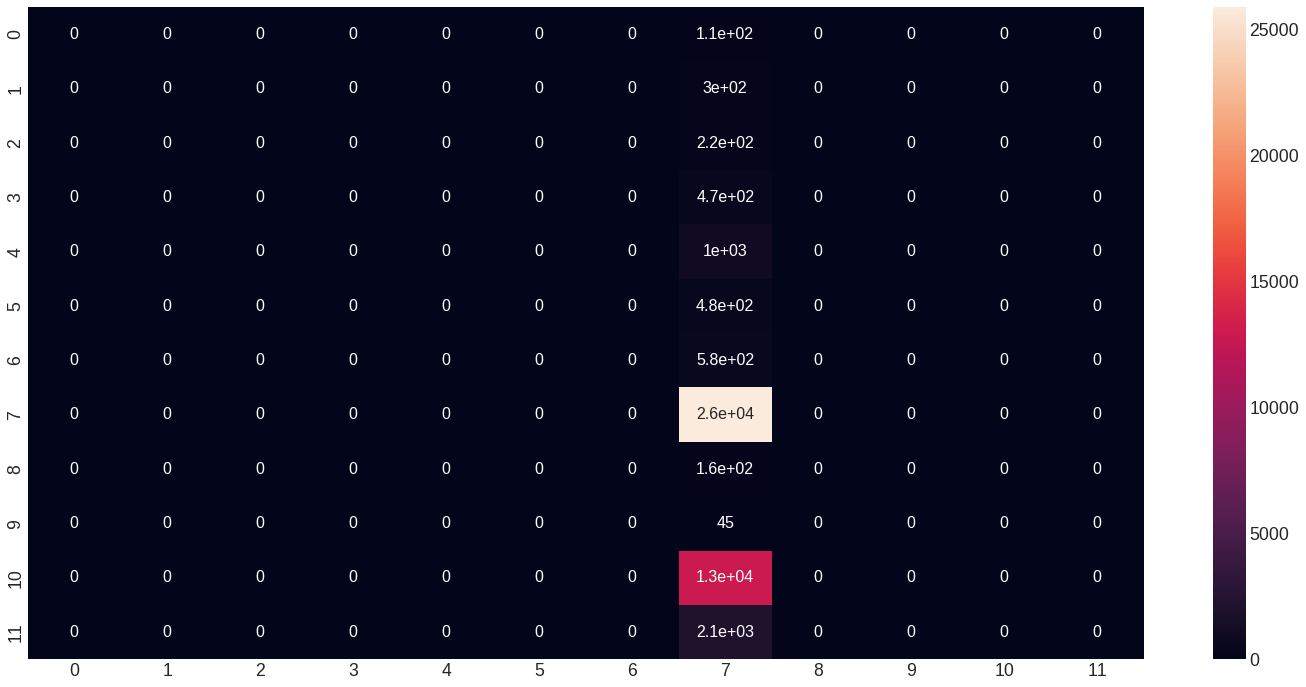

In [76]:
cm = mtr.confusion_matrix(y_valid, y_pred)
sns.heatmap(cm, annot=True);

### 7.1.1 Cross Validation

In [77]:
dummy_cv = cross_validation('Dummy', DummyClassifier(), X_temp, y_temp, k=5)
dummy_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Accuracy,Precision,Recall,F1,Kappa
Dummy,0.0833 +/- 0.0,0.0487 +/- 0.0,0.5848 +/- 0.0,0.0615 +/- 0.0,0.0 +/- 0.0


## 7.2 Logistic Regression

In [78]:
lg = LogisticRegression(class_weight='balanced')
lg.fit(X_train_sc, y_train)

y_pred = lg.predict(X_valid_sc)

In [79]:
lg_results = ml_scores('Logistic Regression', y_valid, y_pred)
lg_results

,Accuracy,Precision,Recall,F1,Kappa
Logistic Regression,0.1829,0.1751,0.5965,0.1102,0.3799


In [80]:
print(mtr.classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.01      0.46      0.02       111
           1       0.02      0.13      0.03       295
           2       0.01      0.12      0.02       219
           3       0.04      0.17      0.06       466
           4       0.06      0.01      0.02      1042
           5       0.04      0.05      0.04       480
           6       0.05      0.05      0.05       584
           7       0.99      1.00      1.00     25879
           8       0.01      0.07      0.02       158
           9       0.00      0.11      0.00        45
          10       0.74      0.02      0.03     12890
          11       0.13      0.02      0.03      2083

    accuracy                           0.60     44252
   macro avg       0.18      0.18      0.11     44252
weighted avg       0.81      0.60      0.60     44252



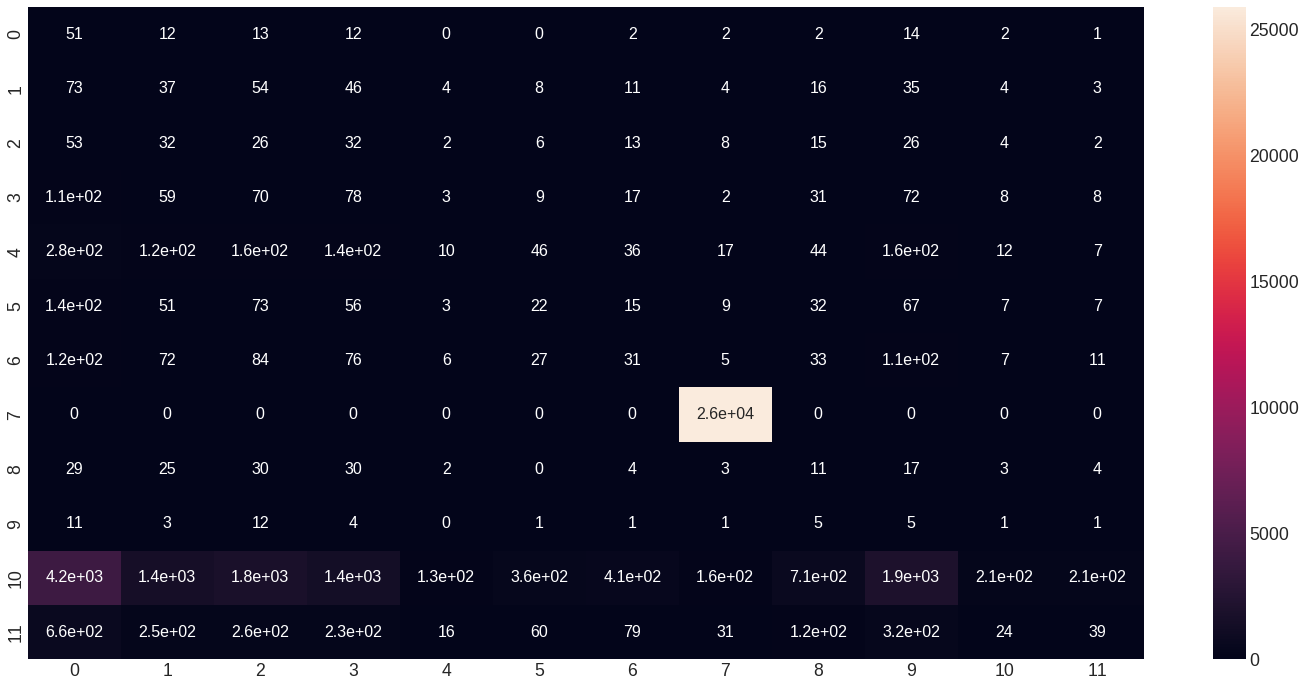

In [81]:
cm = mtr.confusion_matrix(y_valid, y_pred)
sns.heatmap(cm, annot=True);

### 7.2.1 Cross Validation

In [82]:
lg_cv = cross_validation('Logistic Regression CV', LogisticRegression(class_weight='balanced'), X_temp, y_temp)
lg_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Accuracy,Precision,Recall,F1,Kappa
Logistic Regression CV,0.1816 +/- 0.0058,0.179 +/- 0.0085,0.6007 +/- 0.0035,0.1105 +/- 0.0035,0.3863 +/- 0.0044


## 7.3 Random Forest

In [83]:
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(X_train_sc, y_train)

y_pred = rf.predict(X_valid_sc)

In [84]:
rf_results = ml_scores('Random Forest', y_valid, y_pred)
rf_results

,Accuracy,Precision,Recall,F1,Kappa
Random Forest,0.1676,0.1882,0.871,0.1563,0.7607


In [85]:
print(mtr.classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       111
           1       0.05      0.00      0.01       295
           2       0.17      0.00      0.01       219
           3       0.00      0.00      0.00       466
           4       0.09      0.00      0.01      1042
           5       0.05      0.00      0.01       480
           6       0.10      0.01      0.01       584
           7       1.00      1.00      1.00     25879
           8       0.00      0.00      0.00       158
           9       0.00      0.00      0.00        45
          10       0.70      0.98      0.82     12890
          11       0.10      0.01      0.02      2083

    accuracy                           0.87     44252
   macro avg       0.19      0.17      0.16     44252
weighted avg       0.80      0.87      0.82     44252



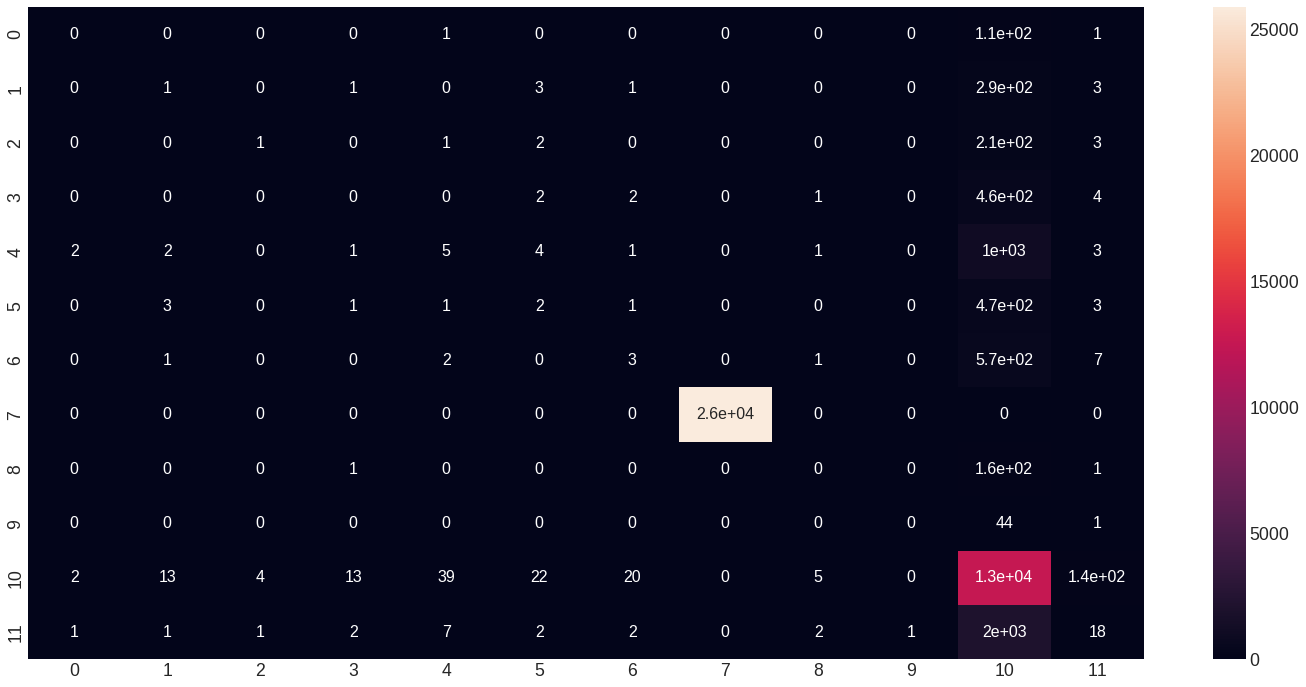

In [86]:
cm = mtr.confusion_matrix(y_valid, y_pred)
sns.heatmap(cm, annot=True);

### 7.3.1 Cross Validation

In [87]:
rf_cv = cross_validation('Random Forest CV', RandomForestClassifier(class_weight='balanced'), X_temp, y_temp)
rf_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Accuracy,Precision,Recall,F1,Kappa
Random Forest CV,0.1671 +/- 0.0002,0.1741 +/- 0.0047,0.8718 +/- 0.0005,0.1551 +/- 0.0005,0.762 +/- 0.0008


## 7.4 Extra Trees

In [88]:
ext = ExtraTreesClassifier(class_weight='balanced')
ext.fit(X_train_sc, y_train)

y_pred = ext.predict(X_valid_sc)

In [89]:
ext_results = ml_scores('Extra Trees', y_valid, y_pred)
ext_results

,Accuracy,Precision,Recall,F1,Kappa
Extra Trees,0.1672,0.1688,0.8572,0.1605,0.7379


In [90]:
print(mtr.classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       111
           1       0.00      0.00      0.00       295
           2       0.02      0.00      0.01       219
           3       0.05      0.01      0.02       466
           4       0.07      0.02      0.02      1042
           5       0.02      0.00      0.01       480
           6       0.05      0.01      0.02       584
           7       1.00      1.00      1.00     25879
           8       0.00      0.00      0.00       158
           9       0.00      0.00      0.00        45
          10       0.70      0.93      0.80     12890
          11       0.12      0.03      0.05      2083

    accuracy                           0.86     44252
   macro avg       0.17      0.17      0.16     44252
weighted avg       0.80      0.86      0.82     44252



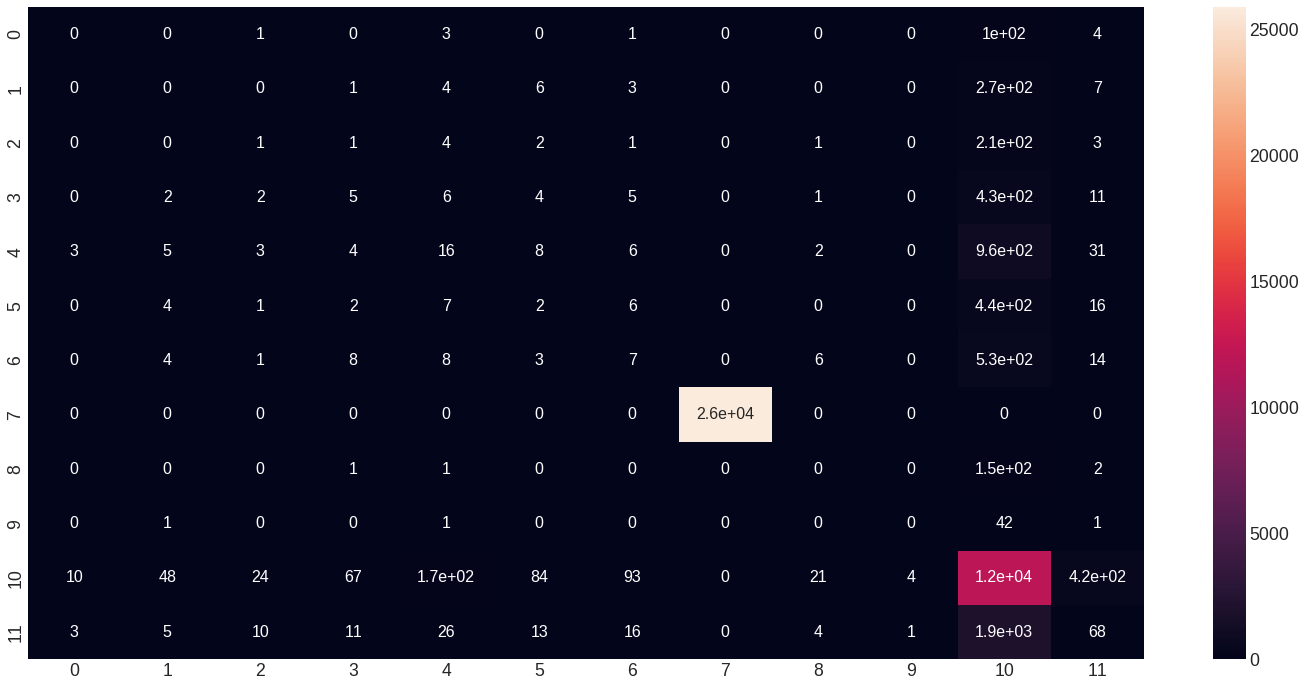

In [91]:
cm = mtr.confusion_matrix(y_valid, y_pred)
sns.heatmap(cm, annot=True);

### 7.4.1 Cross Validation

In [92]:
ext_cv = cross_validation('Extra Trees CV', ExtraTreesClassifier(class_weight='balanced'), X_temp, y_temp)
ext_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Accuracy,Precision,Recall,F1,Kappa
Extra Trees CV,0.168 +/- 0.0006,0.1718 +/- 0.0028,0.8568 +/- 0.0005,0.162 +/- 0.0009,0.7374 +/- 0.0008


## 7.6 Bagging + Logistic Regression

In [93]:
bag = BaggingClassifier(base_estimator=LogisticRegression(class_weight='balanced'), n_estimators=10)
bag.fit(X_train_sc, y_train)

y_pred = bag.predict(X_valid_sc)

In [94]:
bag_results = ml_scores('Bagging', y_valid, y_pred)
bag_results

,Accuracy,Precision,Recall,F1,Kappa
Bagging,0.1848,0.1746,0.5975,0.1105,0.3791


In [95]:
print(mtr.classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.01      0.42      0.02       111
           1       0.02      0.09      0.03       295
           2       0.01      0.14      0.02       219
           3       0.03      0.13      0.05       466
           4       0.07      0.01      0.02      1042
           5       0.04      0.08      0.05       480
           6       0.06      0.05      0.05       584
           7       0.99      1.00      0.99     25879
           8       0.01      0.05      0.02       158
           9       0.00      0.20      0.01        45
          10       0.74      0.02      0.04     12890
          11       0.13      0.02      0.03      2083

    accuracy                           0.60     44252
   macro avg       0.17      0.18      0.11     44252
weighted avg       0.80      0.60      0.60     44252



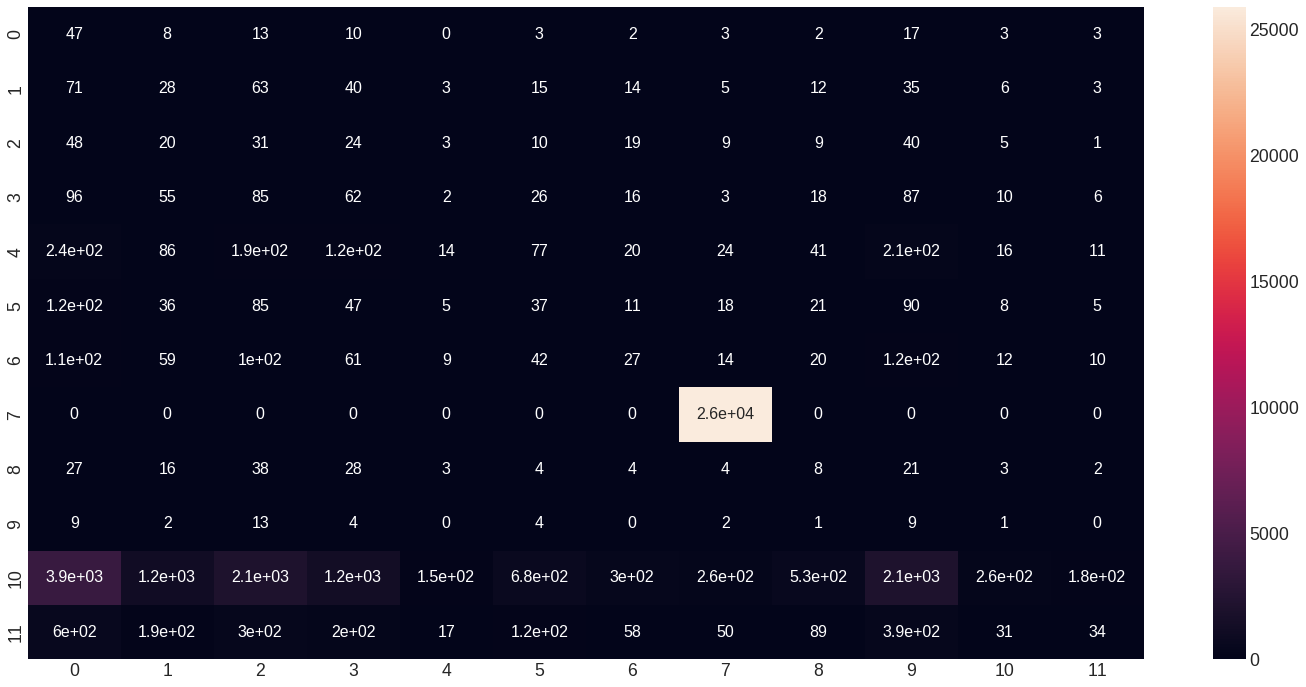

In [96]:
cm = mtr.confusion_matrix(y_valid, y_pred)
sns.heatmap(cm, annot=True);

### 7.6.1 Cross Validation

In [97]:
bag_cv = cross_validation('Bagging CV', BaggingClassifier(base_estimator=LogisticRegression(class_weight='balanced'), n_estimators=10), X_temp, y_temp)
bag_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Accuracy,Precision,Recall,F1,Kappa
Bagging CV,0.1834 +/- 0.0057,0.1691 +/- 0.0055,0.6012 +/- 0.0019,0.1127 +/- 0.0026,0.3873 +/- 0.0024


## 7.7 AdaBoost + Logistic Regression

In [98]:
ada = AdaBoostClassifier(base_estimator=LogisticRegression(class_weight='balanced'), n_estimators=10)
ada.fit(X_train_sc, y_train)

y_pred = ada.predict(X_valid_sc)

In [99]:
ada_results = ml_scores('AdaBoost', y_valid, y_pred)
ada_results

,Accuracy,Precision,Recall,F1,Kappa
AdaBoost,0.1805,0.1746,0.5934,0.1084,0.3792


In [100]:
print(mtr.classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.01      0.27      0.02       111
           1       0.02      0.13      0.04       295
           2       0.01      0.11      0.02       219
           3       0.03      0.17      0.05       466
           4       0.07      0.02      0.03      1042
           5       0.04      0.10      0.06       480
           6       0.04      0.09      0.05       584
           7       1.00      1.00      1.00     25879
           8       0.01      0.12      0.03       158
           9       0.00      0.16      0.00        45
          10       0.74      0.00      0.01     12890
          11       0.12      0.00      0.01      2083

    accuracy                           0.59     44252
   macro avg       0.17      0.18      0.11     44252
weighted avg       0.81      0.59      0.59     44252



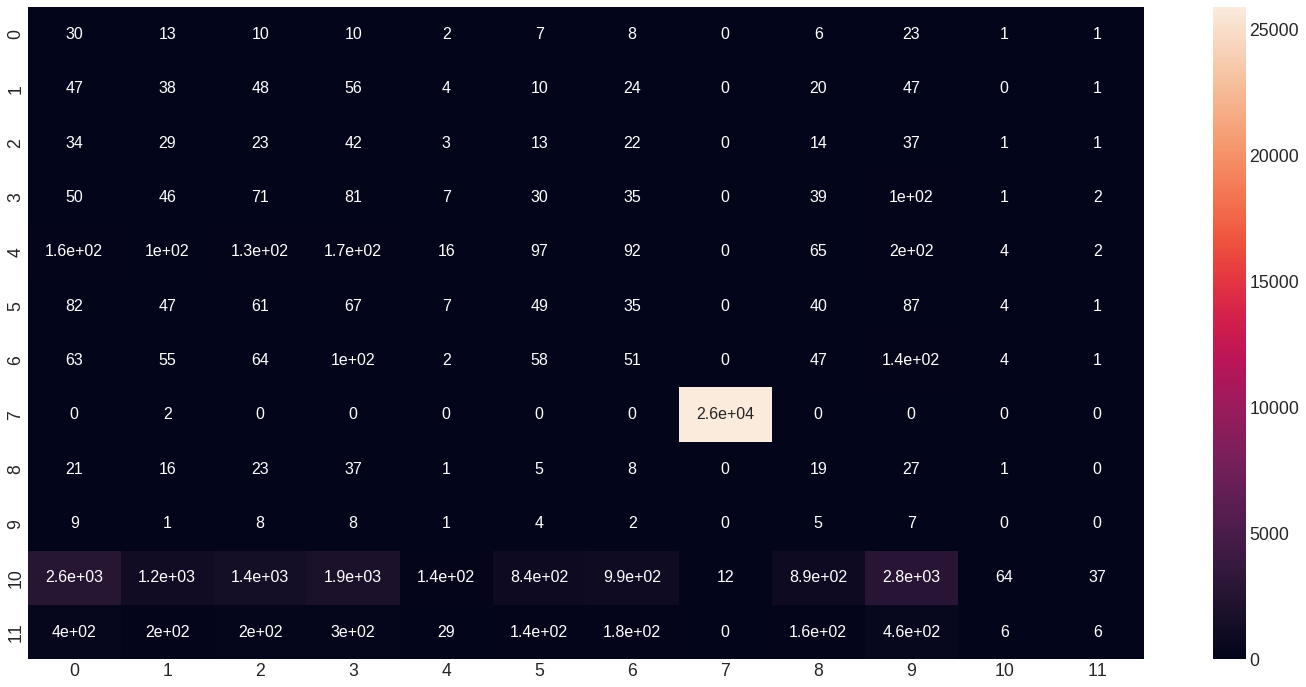

In [101]:
cm = mtr.confusion_matrix(y_valid, y_pred)
sns.heatmap(cm, annot=True);

### 7.7.1 Cross Validation

In [102]:
ada_cv = cross_validation('AdaBoost CV', AdaBoostClassifier(base_estimator=LogisticRegression(class_weight='balanced'), n_estimators=10), X_temp, y_temp)
ada_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Accuracy,Precision,Recall,F1,Kappa
AdaBoost CV,0.1687 +/- 0.0031,0.1642 +/- 0.0077,0.5865 +/- 0.0008,0.0893 +/- 0.0007,0.371 +/- 0.0008


## 7.8 Compare Model's Performance

### 7.8.1 Single Performance

In [105]:
modeling_performance = pd.concat([dummy_results, lg_results, rf_results, ext_results, bag_results, ada_results])
modeling_performance.sort_values(by='Accuracy', ascending=False)

,Accuracy,Precision,Recall,F1,Kappa
Bagging,0.1848,0.1746,0.5975,0.1105,0.3791
Logistic Regression,0.1829,0.1751,0.5965,0.1102,0.3799
AdaBoost,0.1805,0.1746,0.5934,0.1084,0.3792
Random Forest,0.1676,0.1882,0.8710,0.1563,0.7607
Extra Trees,0.1672,0.1688,0.8572,0.1605,0.7379
dummy,0.0833,0.0487,0.5848,0.0615,0.0000


### 7.8.2 Cross Validation Perfromance

In [106]:
modeling_performance_cv = pd.concat([dummy_cv, lg_cv, rf_cv, ext_cv, bag_cv, ada_cv])
modeling_performance_cv.sort_values(by='Accuracy', ascending=False)

,Accuracy,Precision,Recall,F1,Kappa
Bagging CV,0.1834 +/- 0.0057,0.1691 +/- 0.0055,0.6012 +/- 0.0019,0.1127 +/- 0.0026,0.3873 +/- 0.0024
Logistic Regression CV,0.1816 +/- 0.0058,0.179 +/- 0.0085,0.6007 +/- 0.0035,0.1105 +/- 0.0035,0.3863 +/- 0.0044
AdaBoost CV,0.1687 +/- 0.0031,0.1642 +/- 0.0077,0.5865 +/- 0.0008,0.0893 +/- 0.0007,0.371 +/- 0.0008
Extra Trees CV,0.168 +/- 0.0006,0.1718 +/- 0.0028,0.8568 +/- 0.0005,0.162 +/- 0.0009,0.7374 +/- 0.0008
Random Forest CV,0.1671 +/- 0.0002,0.1741 +/- 0.0047,0.8718 +/- 0.0005,0.1551 +/- 0.0005,0.762 +/- 0.0008
Dummy,0.0833 +/- 0.0,0.0487 +/- 0.0,0.5848 +/- 0.0,0.0615 +/- 0.0,0.0 +/- 0.0


# 8.0 Hyperparameter Fine Tuning

## 8.1 AdaBoosting + Logistic Regression

In [109]:
params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'class_weight': ['balanced'],
    'max_iter': [100, 500, 1000]
}

In [110]:
lg_rs = RandomizedSearchCV(
    LogisticRegression(), 
    param_distributions=params, 
    scoring=mtr.balanced_accuracy_score, 
    cv=StratifiedKFold(n_splits=5)
)

lg_rs.fit(X_params, y_temp)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=LogisticRegression(),
                   param_distributions={'C': [0.001, 0.01, 0.1, 1, 10, 100,
                                              1000],
                                        'class_weight': ['balanced'],
                                        'max_iter': [100, 500, 1000]},
                   scoring=<function balanced_accuracy_score at 0x7f522a6b3b80>)

In [111]:
best_params = lg_rs.best_params_
best_params

{'max_iter': 1000, 'class_weight': 'balanced', 'C': 0.001}

In [50]:
best_params = {'max_iter': 1000, 'class_weight': 'balanced', 'C': 0.001}

lg_best = LogisticRegression(max_iter=best_params['max_iter'], class_weight=best_params['class_weight'], C=best_params['C'])
bag_lg_best = BaggingClassifier(base_estimator=lg_best, n_estimators=10)

In [52]:
bag_lg_best.fit(X_train_sc, y_train)
y_pred = bag_lg_best.predict(X_valid_sc)

In [53]:
bag_lg_best_results = ml_scores('Bagging Logistic Best', y_valid, y_pred)
bag_lg_best_results

,Accuracy,Precision,Recall,F1,Kappa
Bagging Logistic Best,0.1875,0.1822,0.5965,0.1121,0.3778


In [54]:
print(mtr.classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.01      0.43      0.02       111
           1       0.02      0.11      0.03       295
           2       0.01      0.10      0.02       219
           3       0.03      0.23      0.06       466
           4       0.07      0.02      0.03      1042
           5       0.04      0.07      0.05       480
           6       0.04      0.05      0.04       584
           7       0.98      1.00      0.99     25879
           8       0.01      0.05      0.02       158
           9       0.00      0.16      0.00        45
          10       0.80      0.01      0.02     12890
          11       0.16      0.02      0.04      2083

    accuracy                           0.60     44252
   macro avg       0.18      0.19      0.11     44252
weighted avg       0.82      0.60      0.59     44252



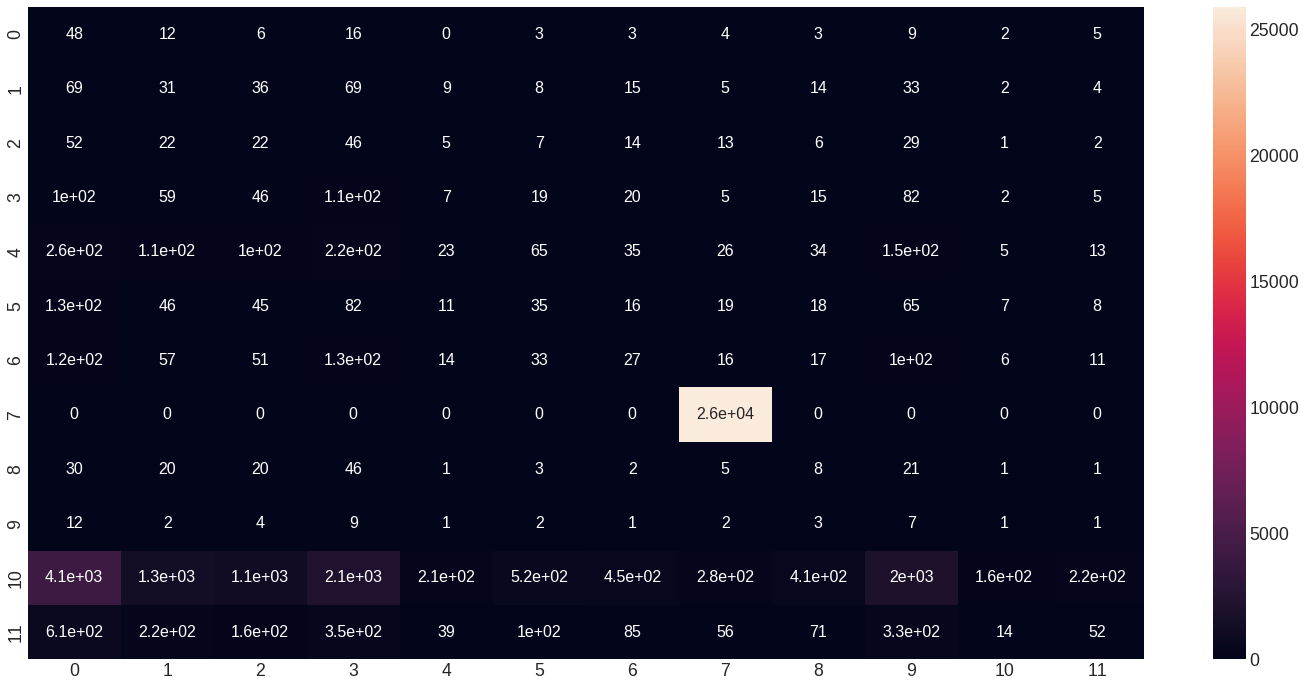

In [55]:
cm = mtr.confusion_matrix(y_valid, y_pred)
sns.heatmap(cm, annot=True);

### 8.1.1 Cross Validation

In [56]:
bag_cv = cross_validation('Bagging Logistic Regression Best CV', BaggingClassifier(base_estimator=lg_best, n_estimators=10), X_temp, y_temp)
bag_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Accuracy,Precision,Recall,F1,Kappa
Bagging Logistic Regression Best CV,0.1878 +/- 0.0079,0.1717 +/- 0.0049,0.6043 +/- 0.0052,0.1151 +/- 0.0036,0.3916 +/- 0.0062


# 9.0 Conclusions

## 9.1 Final Model

In [59]:
lg_best = LogisticRegression(max_iter=best_params['max_iter'], class_weight=best_params['class_weight'], C=best_params['C'])
final_model = BaggingClassifier(base_estimator=lg_best, n_estimators=10)

final_model.fit(X_params_sc, y_temp)

BaggingClassifier(base_estimator=LogisticRegression(C=0.001,
                                                    class_weight='balanced',
                                                    max_iter=1000))

### 9.1.1 Unseen Data Result

In [60]:
y_pred = final_model.predict(X_test_sc)

In [62]:
final_model_results = ml_scores('Final Model', y_test, y_pred)
final_model_results

,Accuracy,Precision,Recall,F1,Kappa
Final Model,0.1932,0.1779,0.603,0.1184,0.3861


## 9.2 Business Questions

# 10.0 Model Deploy

## 10.1 Saving

### 10.1.1 Model

In [63]:
joblib.dump(final_model, '../models/bagging_logistic_regression_cycle1.joblib')

['../models/bagging_logistic_regression_cycle1.joblib']

### 10.1.2 Parameters

In [31]:
joblib.dump(le, '../parameters/label_encoder_cycle1.joblib')

joblib.dump(ohe, '../parameters/one_hot_encoder_cycle1.joblib')

joblib.dump(te, '../parameters/target_encoder_cycle1.joblib')

joblib.dump(rs, '../parameters/robust_scaler_cycle1.joblib')

['../parameters/robust_scaler_cycle1.joblib']